# **1. Import Libraries**

In [ ]:
# Import package leia-br: Python library designed to handle Brazilian documents
!pip install leia-br

# Install catboost Library
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.0/130.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


In [ ]:

# Core Libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
%matplotlib inline

# Set color palette for Seaborn
colors = ["#26536f", "#3b96b7", "#749ca8", "#b6a98d", "#c78a4d", "#854927"]
sns.set_palette(colors)

# Text Processing Libraries
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
from nltk import ngrams

# Sentiment Analysis
from LeIA import SentimentIntensityAnalyzer

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Machine Learning Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report,
    confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, auc
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **`2. Read,Merge and Data Exploration`**

In [ ]:
# Read files into DataFrames
df_items = pd.read_csv('olist_order_items_dataset.csv')
df_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_products = pd.read_csv('olist_products_dataset.csv')
df_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
df_sellers = pd.read_csv('olist_sellers_dataset.csv')
df_payments = pd.read_csv('olist_order_payments_dataset.csv')
df_customers = pd.read_csv('olist_customers_dataset.csv')
df_category = pd.read_csv('product_category_name_translation.csv')

In [ ]:
# Merging Dataframes
df = df_orders.merge(df_items, on='order_id', how='inner')
df = df.merge(df_payments, on='order_id', how='inner', validate='m:m')
df = df.merge(df_reviews, on='order_id', how='inner')
df = df.merge(df_products, on='product_id', how='inner')
df = df.merge(df_customers, on='customer_id', how='inner')
df = df.merge(df_sellers, on='seller_id', how='inner')

In [ ]:
df.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00              1   
1           2017-10-18 00:00:00              1   
2           2017-10-18 00:00:00              1   
3           2018-08-13 00:00:00              1   
4           2018-09-04 00:00:00              1   

                         product_id  ... product_length_cm product_height_cm  \
0  87285b34884572647811a353c7ac498a  ...              19.0               8.0   
1  87285b34884572647811a353c7ac498a  ...              19.0               8.0   
2  87285b34884572647811a353c7ac498a  ...              19.0               8.0   
3  595fac2a385ac33a80bd5114aec74eb8  ...              19.0              13.0   
4  aa4383b373c6aca5d8797843e5594415  ...              24.0              19.0   

   product_width_cm                customer_unique_id  \
0              13.0  7c396fd4830fd04220f754e42b4e5bff   
1              13.0  7c396fd4830fd04220f754e42b4e5bff   
2              13.0  7c396fd4830fd04220f754e42b4e5bff   
3              19.0  af07308b275d755c9edb36a90c618231   
4              21.0  3a653a41f6f9fc3d2a113cf8398680e8   

   customer_zip_code_prefix customer_city  customer_state  \
0                      3149     sao paulo              SP   
1                      3149     sao paulo              SP   
2                      3149     sao paulo              SP   
3                     47813     barreiras              BA   
4                     75265    vianopolis              GO   

   seller_zip_code_prefix     seller_city  seller_state  
0                    9350            maua            SP  
1                    9350            maua            SP  
2                    9350            maua            SP  
3                   31570  belo horizonte            SP  
4                   14840         guariba            SP  

[5 rows x 39 columns]

In [ ]:
df.shape

(117329, 39)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117329 non-null  object 
 1   customer_id                    117329 non-null  object 
 2   order_status                   117329 non-null  object 
 3   order_purchase_timestamp       117329 non-null  object 
 4   order_approved_at              117314 non-null  object 
 5   order_delivered_carrier_date   116094 non-null  object 
 6   order_delivered_customer_date  114858 non-null  object 
 7   order_estimated_delivery_date  117329 non-null  object 
 8   order_item_id                  117329 non-null  int64  
 9   product_id                     117329 non-null  object 
 10  seller_id                      117329 non-null  object 
 11  shipping_limit_date            117329 non-null  object 
 12  price                         

In [ ]:
df.isna().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    15
order_delivered_carrier_date       1235
order_delivered_customer_date      2471
order_estimated_delivery_date         0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
payment_sequential                    0
payment_type                          0
payment_installments                  0
payment_value                         0
review_id                             0
review_score                          0
review_comment_title             103437
review_comment_message            67650
review_creation_date                  0
review_answer_timestamp               0
product_category_name              1695
product_name_lenght                1695
product_description_lenght         1695
product_photos_qty                 1695
product_weight_g                     20
product_length_cm                    20
product_height_cm                    20
product_width_cm                     20
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
seller_zip_code_prefix                0
seller_city                           0
seller_state                          0
dtype: int64

In [ ]:
print(df['order_purchase_timestamp'])
print(df['order_delivered_customer_date'])

0         2017-10-02 10:56:33
1         2017-10-02 10:56:33
2         2017-10-02 10:56:33
3         2018-07-24 20:41:37
4         2018-08-08 08:38:49
                 ...         
117324    2018-02-06 12:58:58
117325    2017-08-27 14:46:43
117326    2018-01-08 21:28:27
117327    2018-01-08 21:28:27
117328    2018-03-08 20:57:30
Name: order_purchase_timestamp, Length: 117329, dtype: object
0         2017-10-10 21:25:13
1         2017-10-10 21:25:13
2         2017-10-10 21:25:13
3         2018-08-07 15:27:45
4         2018-08-17 18:06:29
                 ...         
117324    2018-02-28 17:37:56
117325    2017-09-21 11:24:17
117326    2018-01-25 23:32:54
117327    2018-01-25 23:32:54
117328    2018-03-16 13:08:30
Name: order_delivered_customer_date, Length: 117329, dtype: object


In [ ]:
df['order_purchase_timestamp'].dtype

dtype('O')

In [ ]:
# Ensure timestamps are in datetime format
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

# Create useful features from order_purchase_timestamp
df['day_of_week_int'] = df['order_purchase_timestamp'].dt.weekday + 1  # Day of week as integer (1 = Monday, etc.)
df['hour'] = df['order_purchase_timestamp'].dt.hour                    # Hour of day
df['month'] = df['order_purchase_timestamp'].dt.month                  # Month as integer
df['year'] = df['order_purchase_timestamp'].dt.year                    # Year as integer
df['date'] = df['order_purchase_timestamp'].dt.to_period('M')          # Monthly period for time series analysis

# Calculate delivery time in days
df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days


In [ ]:
# Typo in the column : product_name_lenght- Rename
df.rename(columns={'product_name_lenght': 'product_name_length'}, inplace=True)

# **3. Exploratory Data Analysis**

## Monthly Sales Trend (Line Plot)

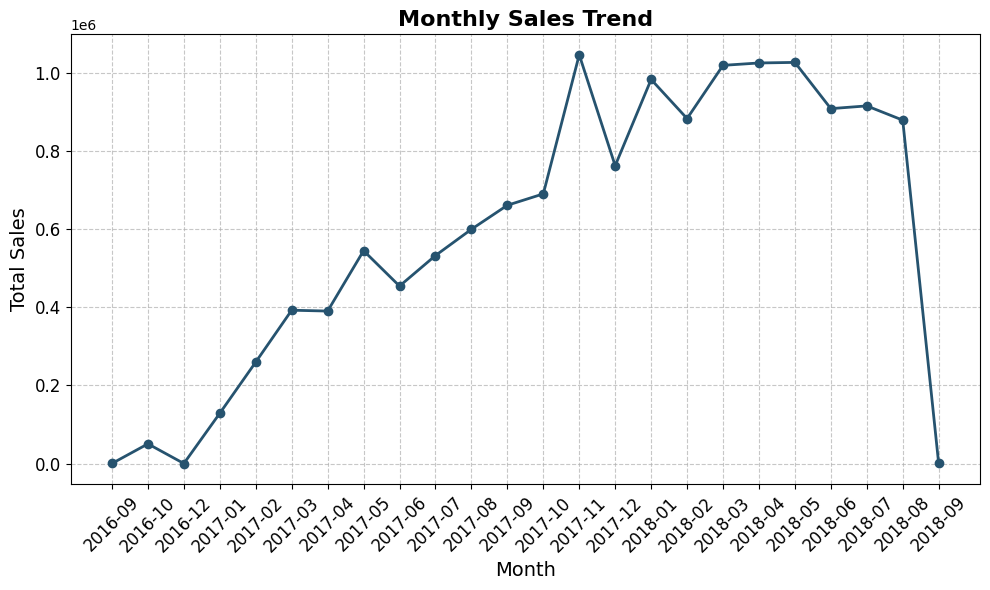

In [ ]:
# Monthly sales trend
monthly_sales = df.groupby(df['order_purchase_timestamp'].dt.to_period('M')).agg({'price': 'sum'})

# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Plot the data with custom colors
plt.plot(monthly_sales.index.astype(str), monthly_sales['price'],
         marker='o', linestyle='-', color=colors[0], linewidth=2)

# Adding titles and labels
plt.title('Monthly Sales Trend', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)

# Customize the ticks
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines for better readability
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

## Product Distribution Across Categories(Bar Plot)

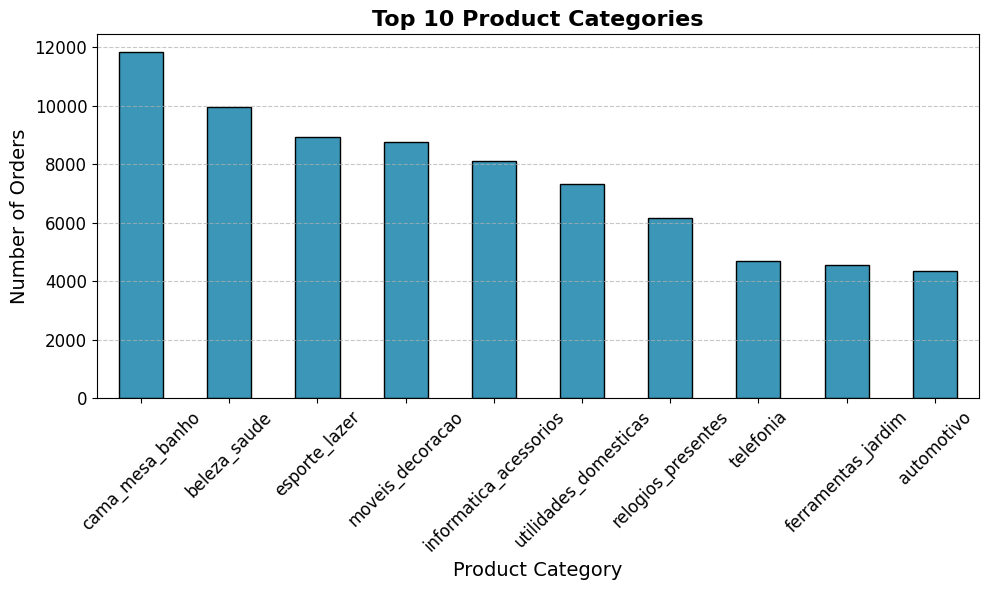

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Top 10 product categories based on the frequency of occurrences
top_categories = df['product_category_name'].value_counts().head(10)
top_categories.plot(kind='bar', color=colors[1], edgecolor='black')

# Adding titles and labels
plt.title('Top 10 Product Categories', fontsize=16, fontweight='bold')
plt.xlabel('Product Category', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)

# Customize ticks
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Total Sales by Product Category (Bar Plot)

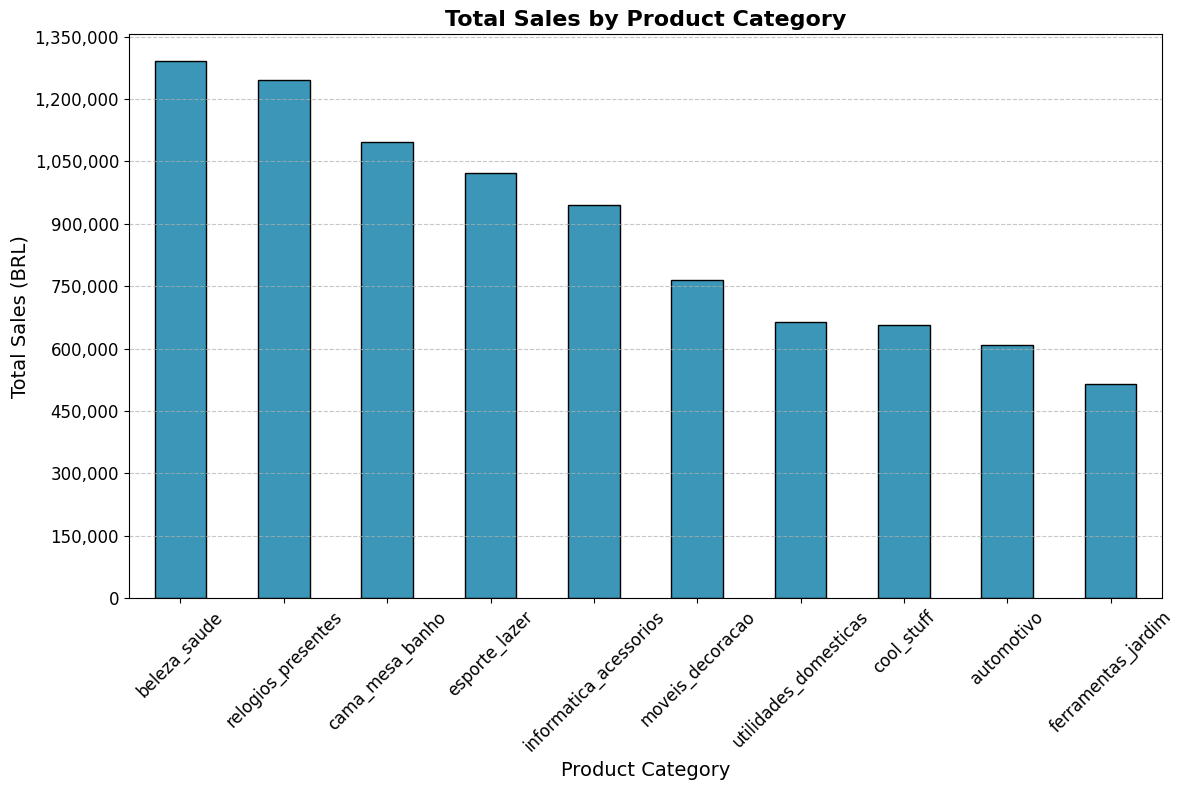

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Step 1: Group by 'product_category_name' and sum the 'price' (total sales per category)
top_category_sales = df.groupby('product_category_name')['price'].sum()

# Step 2: Sort the values and get the top 10 categories with the highest total sales
top_categories = top_category_sales.sort_values(ascending=False).head(10)

# Plot the data
top_categories.plot(kind='bar', color=colors[1], edgecolor='black')

# Adding titles and labels
plt.title('Total Sales by Product Category', fontsize=16, fontweight='bold')
plt.xlabel('Product Category', fontsize=14)
plt.ylabel('Total Sales (BRL)', fontsize=14)

# Customize ticks
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Use MaxNLocator for better formatting of the Y-axis
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # This ensures integer values on the Y-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))  # To show as rounded numbers

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Sales distribution by Payment Method (Pie Chart)

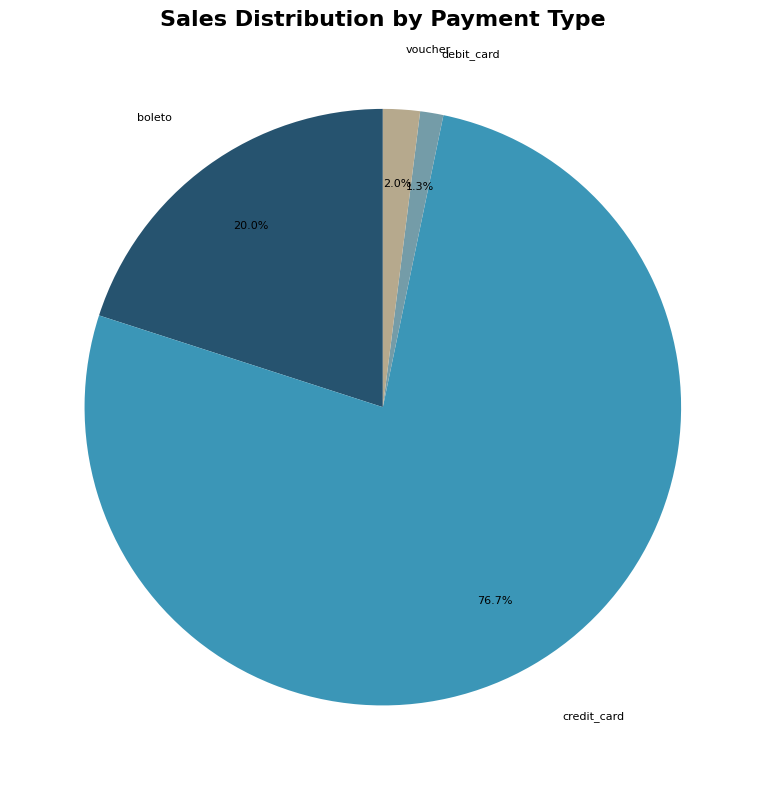

In [ ]:
# Total revenue for each payment type
# Set the figure size

plt.figure(figsize=(8, 8))

# Example: Proportion of total sales by payment type
sales_by_payment = df.groupby('payment_type')['payment_value'].sum()
sales_by_payment.plot(kind='pie', autopct='%1.1f%%', startangle=90,legend=False,colors=colors,
                      labeldistance=1.2,  # Move labels further out
                      pctdistance=0.75,  # Move percentages further out
                      fontsize=8)  # Increase font size)

# Adding title
plt.title('Sales Distribution by Payment Type', fontsize=16, fontweight='bold')

# Hide the y-label for better aesthetics
plt.ylabel('')

plt.tight_layout()
plt.show()

## Total Sales by City (Bar Chart)

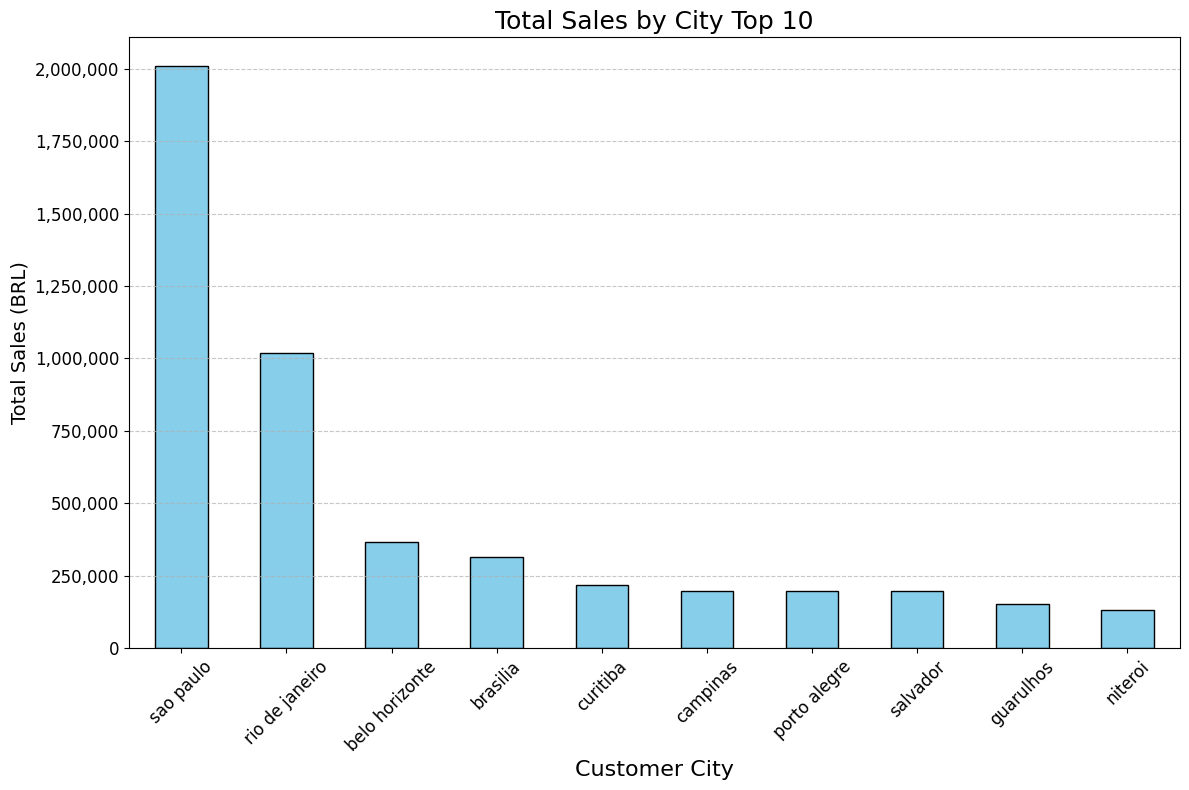

In [ ]:
# Grouping by 'customer_city' and summing the 'price' to get total sales by city
sales_by_city = df.groupby('customer_city')['price'].sum().sort_values(ascending=False)

# Plotting the bar chart for sales by city
plt.figure(figsize=(12, 8))
sales_by_city.head(10).plot(kind='bar', color='skyblue', edgecolor='black')

# Adding labels and title
plt.title('Total Sales by City Top 10', fontsize=18)
plt.xlabel('Customer City', fontsize=16)
plt.ylabel('Total Sales (BRL)', fontsize=14)

# Customize ticks
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Use MaxNLocator for better formatting of the Y-axis
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # This ensures integer values on the Y-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))  # To show as rounded numbers

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

## Distribution of Review Scores (Histogram)

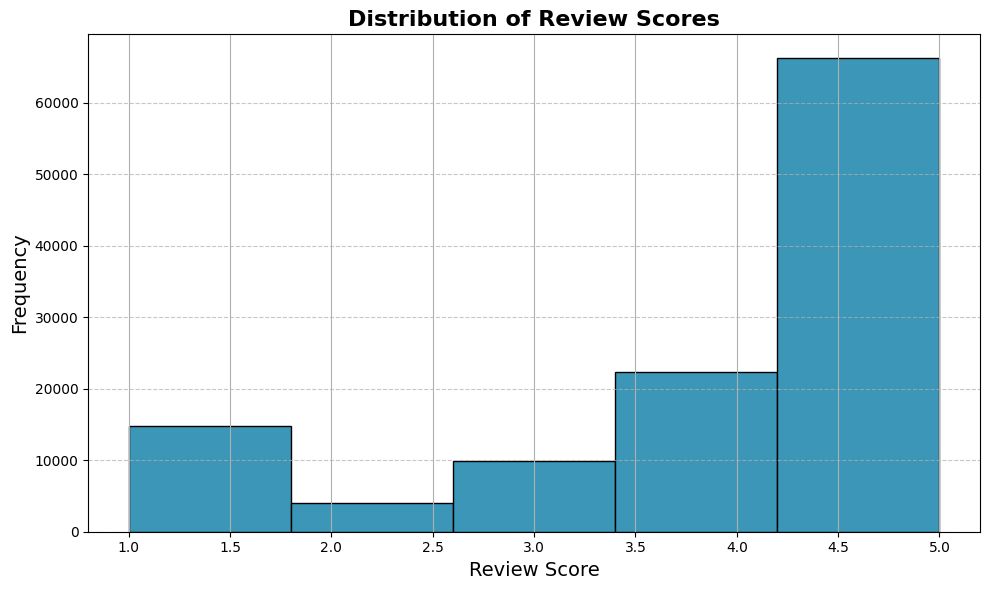

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Distribution of review scores
df['review_score'].hist(bins=5, color=colors[1], edgecolor='black')

# Adding titles and labels
plt.title('Distribution of Review Scores', fontsize=16, fontweight='bold')
plt.xlabel('Review Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Correlation Analysis (Heatmap)

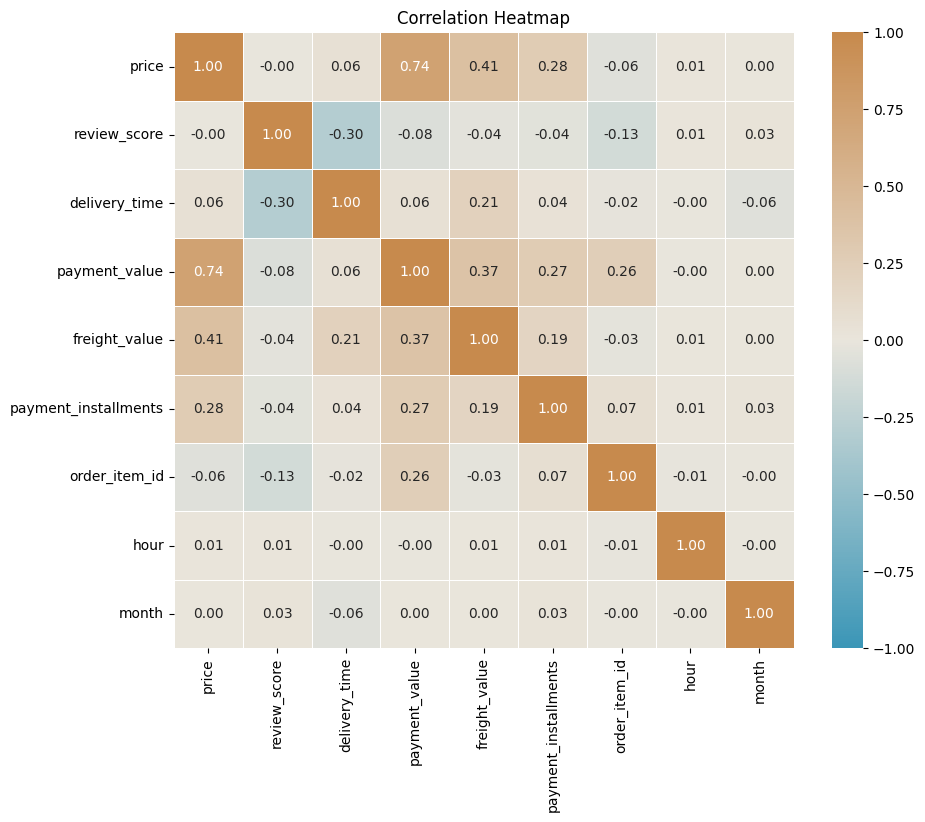

In [ ]:
# Select relevant features for correlation analysis
correlation_features = df[['price', 'review_score', 'delivery_time',
                            'payment_value', 'freight_value',
                            'payment_installments', 'order_item_id',
                            'hour', 'month']]

# Calculate the correlation matrix
correlation = correlation_features.corr()

# Define the custom colormap
custom_colors = ['#3B96B7', '#E9E5DC', '#C78A4D']
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True,cmap=custom_cmap, vmin=-1, vmax=1, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

## Delivery Time by Product Category (Box Plot)

In [ ]:
# Count the occurrences of each product category
category_counts = df['product_category_name'].value_counts()

# Set a threshold to decide which categories to keep
threshold = 3000
common_categories = category_counts[category_counts >= threshold].index

# Create a new column for simplified categories - use numpy for better optimization with large datasets
#df['simplified_category'] = df['product_category_name'].where(df['product_category_name'].isin(common_categories), 'Other')

df['simplified_category'] = np.where(df['product_category_name'].isin(common_categories),
                                      df['product_category_name'], 'Other')


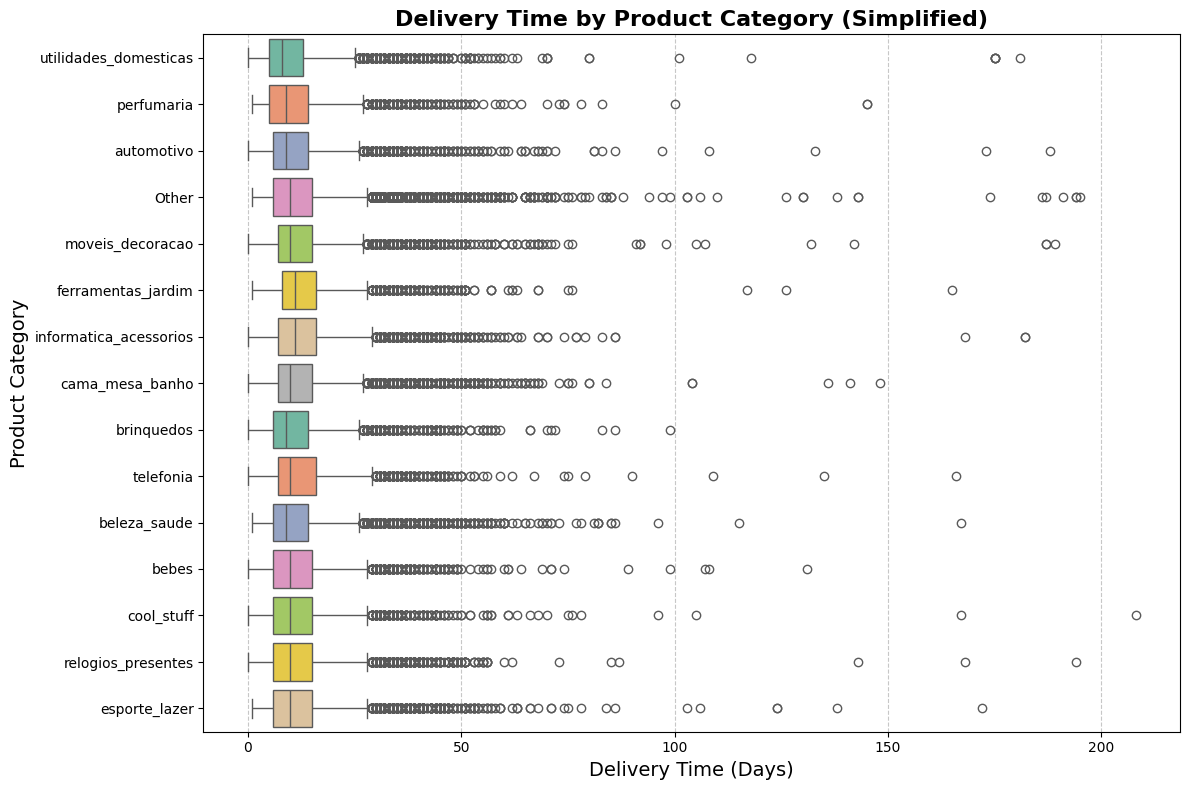

In [ ]:
plt.figure(figsize=(12, 8))

# Horizontal box plot for delivery time by simplified product category
sns.boxplot(x='delivery_time', y='simplified_category', data=df, palette='Set2', hue='simplified_category')

# Overlay swarm plot to show individual points
#sns.swarmplot(x='delivery_time', y='simplified_category', data=df, color='k', alpha=0.6, size=3)

# Adding titles and labels
plt.title('Delivery Time by Product Category (Simplified)', fontsize=16, fontweight='bold')
plt.xlabel('Delivery Time (Days)', fontsize=14)
plt.ylabel('Product Category', fontsize=14)

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Delivery Time by Day of the Week (Violin plot)

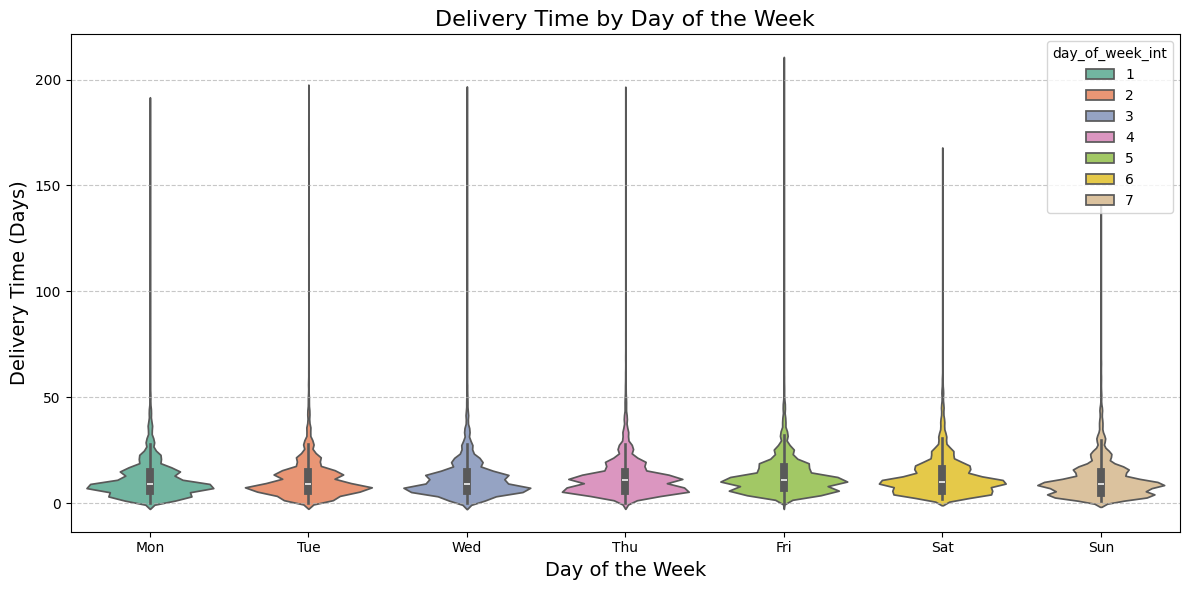

In [ ]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='day_of_week_int', y='delivery_time', palette='Set2', hue='day_of_week_int')
plt.title('Delivery Time by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Delivery Time (Days)', fontsize=14)
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Average Delivery Time by Month (Bar Plot)

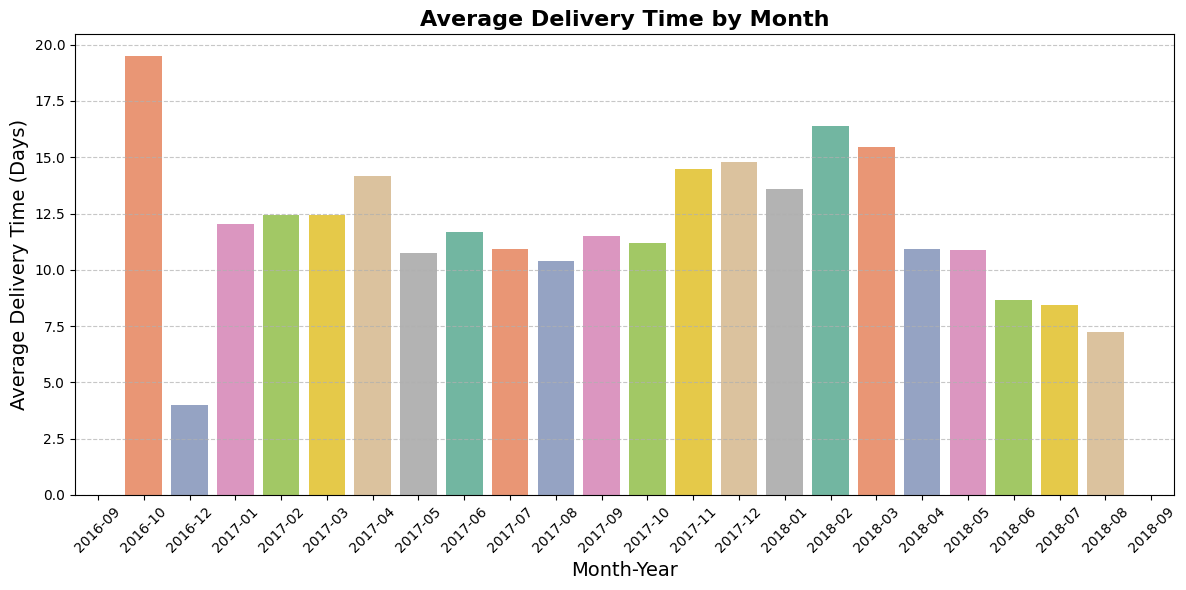

In [ ]:
# Calculate the monthly average delivery time
df['month_year'] = df['order_purchase_timestamp'].dt.to_period('M')
monthly_delivery_time = df.groupby('month_year')['delivery_time'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='month_year', y='delivery_time', data=monthly_delivery_time, palette='Set2', hue='month_year')
plt.title('Average Delivery Time by Month', fontsize=16, fontweight='bold')
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Average Delivery Time (Days)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Word Cloud of Review Comments


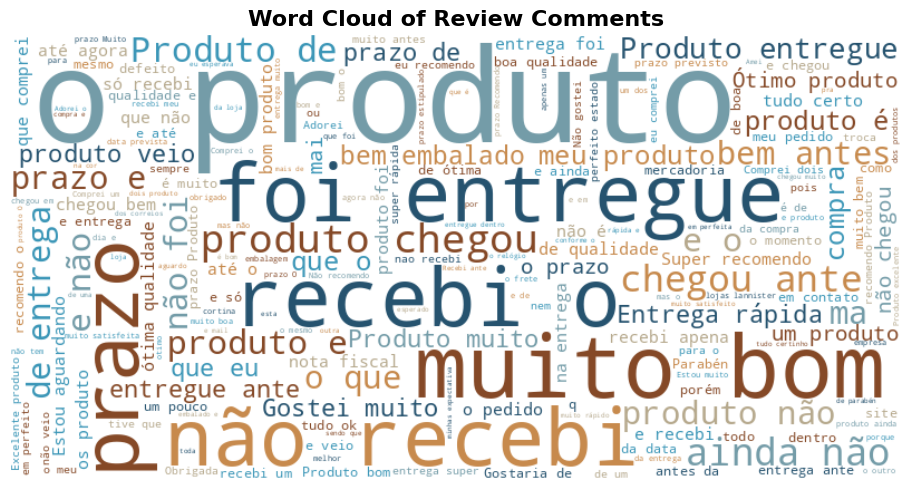

In [ ]:
# Define a color function
def color_func(word, font_size, position, orientation, random_state=42, **kwargs):
    return random.choice(colors)

# Example: Word cloud from review comments
plt.figure(figsize=(10, 5))

wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(' '.join(df['review_comment_message'].dropna()))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud of Review Comments', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Natural Language Processing (NLP)

In [ ]:
# Selecting only necessary columns for NLP analysis
nlp_df = df[['review_comment_title', 'review_comment_message', 'product_category_name']]

In [ ]:
# dataset
nlp_df

review_comment_title  \
0                       NaN   
1                       NaN   
2                       NaN   
3          Muito boa a loja   
4                       NaN   
...                     ...   
117324                  NaN   
117325                  NaN   
117326                  NaN   
117327                  NaN   
117328                  NaN   

                                   review_comment_message  \
0       Não testei o produto ainda, mas ele veio corre...   
1       Não testei o produto ainda, mas ele veio corre...   
2       Não testei o produto ainda, mas ele veio corre...   
3                                    Muito bom o produto.   
4                                                     NaN   
...                                                   ...   
117324       So uma peça que veio rachado mas tudo bem rs   
117325                       Foi entregue antes do prazo.   
117326  Foi entregue somente 1. Quero saber do outro p...   
117327  Foi entregue somente 1. Quero saber do outro p...   
117328                                                NaN   

         product_category_name  
0        utilidades_domesticas  
1        utilidades_domesticas  
2        utilidades_domesticas  
3                   perfumaria  
4                   automotivo  
...                        ...  
117324                   bebes  
117325      eletrodomesticos_2  
117326  informatica_acessorios  
117327  informatica_acessorios  
117328            beleza_saude  

[117329 rows x 3 columns]

In [ ]:
nlp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   review_comment_title    13892 non-null   object
 1   review_comment_message  49679 non-null   object
 2   product_category_name   115634 non-null  object
dtypes: object(3)
memory usage: 2.7+ MB


In [ ]:
print("There are {} product categories in the dataset.".format(nlp_df.product_category_name.nunique()))

There are 73 product categories in the dataset.


## 5. NLP - Data Cleaning

In [ ]:
# Calculating the total number of NaN values in each column of the DataFrame 'nlp_df'
nan_counts = nlp_df.isna().sum()
nan_counts

review_comment_title      103437
review_comment_message     67650
product_category_name       1695
dtype: int64

In [ ]:
# Calculating the total number of NaN values in the 'review_comment_message' column of 'nlp_df'
nan_count_review_comment_message = nlp_df['review_comment_message'].isna().sum()
nan_count_review_comment_message

67650

In [ ]:
# Function to remove duplicates
def remove_duplicates_nlp_df(nlp_df, column_name='review_comment_message'):

    # Remove duplicates based on the specified column, keeping the first occurrence
    nlp_df = nlp_df.drop_duplicates(subset=[column_name], keep='first').reset_index(drop=True)

    # Display the total entries after removing duplicates
    print(f"Total entries after removing duplicates in '{column_name}': {nlp_df.shape[0]}")

    return nlp_df

# Remove duplicates from 'nlp_df' based on the 'review_comment_message' column
nlp_df = remove_duplicates_nlp_df(nlp_df, 'review_comment_message')

# Display the first few records to verify
nlp_df.head()

Total entries after removing duplicates in 'review_comment_message': 35692


review_comment_title                             review_comment_message  \
0                  NaN  Não testei o produto ainda, mas ele veio corre...   
1     Muito boa a loja                               Muito bom o produto.   
2                  NaN                                                NaN   
3                  NaN  O produto foi exatamente o que eu esperava e e...   
4                  NaN               fiquei triste por n ter me atendido.   

   product_category_name  
0  utilidades_domesticas  
1             perfumaria  
2             automotivo  
3               pet_shop  
4                    NaN

In [ ]:
# Function to remove empty rows
def clean_reviews(df):

    # Remove rows where 'review_comment_message' is empty
    df = df.dropna(subset=['review_comment_message', 'review_comment_title', 'product_category_name']).reset_index(drop=True)

    # Remove duplicate rows
    df = df.drop_duplicates(subset=['review_comment_message'])

    return df

# Assuming 'nlp_df' is your dataframe
df_cleaned = clean_reviews(nlp_df)

# Display the first records to check
df_cleaned.head()

review_comment_title                             review_comment_message  \
0     Muito boa a loja                               Muito bom o produto.   
1             Nota dez  Obrigado pela atenção. Lojas lannister perfeit...   
2               Ótimo   Sempre vou comprar aqui pois é a melhor parabéns    
3   NÃO RECOMENDO!!!!   Até o momento não recebi o produto Protetor De...   
4          Enganadores  Foi entregue um produto divergente do que eu h...   

  product_category_name  
0            perfumaria  
1            perfumaria  
2             papelaria  
3                 bebes  
4          climatizacao

## 6. NLP - Text Preprocessing

In [ ]:
# Define Portuguese stopwords
STOP_WORDS = set(stopwords.words('portuguese'))

# Helper function to clean and tokenize text
def clean_and_tokenize(text):
    # Ensure the text is a string
    if not isinstance(text, str):
        return "", []

    # Convert to lowercase, remove punctuation, and split into words
    cleaned_text = text.lower().translate(str.maketrans('', '', string.punctuation))
    words = cleaned_text.split()

    # Remove stopwords and create tokens
    filtered_words = [word for word in words if word not in STOP_WORDS]
    return " ".join(filtered_words), filtered_words

# Main function to preprocess and clean the dataframe
def preprocess_nlp_df(df):
    # Clean, remove stopwords, and tokenize comments
    df[['review_comment_message_clean', 'review_comment_message_tokens']] = df['review_comment_message'].apply(
        lambda text: pd.Series(clean_and_tokenize(text))
    )

    # Remove rows with NaN values in key columns
    df.dropna(subset=['review_comment_title', 'review_comment_message'], inplace=True)

    # Drop duplicate rows based on the 'review_comment_message' and 'review_comment_title' columns
    df.drop_duplicates(subset=['review_comment_message', 'review_comment_title'], inplace=True)

    return df.reset_index(drop=True)

# Preprocess the dataset
nlp_df = preprocess_nlp_df(nlp_df)

# Display the first records to check
nlp_df[['review_comment_message', 'review_comment_message_clean', 'review_comment_message_tokens']].head()

review_comment_message  \
0                               Muito bom o produto.   
1  Obrigado pela atenção. Lojas lannister perfeit...   
2  Sempre vou comprar aqui pois é a melhor parabéns    
3  Até o momento não recebi o produto Protetor De...   
4  Foi entregue um produto divergente do que eu h...   

                        review_comment_message_clean  \
0                                        bom produto   
1     obrigado atenção lojas lannister perfeito tudo   
2       sempre vou comprar aqui pois melhor parabéns   
3  momento recebi produto protetor colchão berço ...   
4  entregue produto divergente havia comprado alé...   

                       review_comment_message_tokens  
0                                     [bom, produto]  
1  [obrigado, atenção, lojas, lannister, perfeito...  
2  [sempre, vou, comprar, aqui, pois, melhor, par...  
3  [momento, recebi, produto, protetor, colchão, ...  
4  [entregue, produto, divergente, havia, comprad...

# 7. Sentiment Analysis of Customer Reviews : LeIA Library

In [ ]:
# Initialize the Sentiment Analyzer once
analyzer = SentimentIntensityAnalyzer()

def classify_sentiment(df, column_name='review_comment_message_clean'):

    # Vectorized function to get sentiment classification
    def get_sentiment_classification(text):
        scores = analyzer.polarity_scores(text)
        if scores['compound'] >= 0.05:
            return 'Positive'
        elif scores['compound'] <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'

   # Apply sentiment analysis using map for faster iteration
    df[f'{column_name}_sentiment'] = df[column_name].map(get_sentiment_classification)
    return df

# Classify sentiment in 'nlp_df' based on the 'review_comment_message_clean' column
nlp_df = classify_sentiment(nlp_df, 'review_comment_message_clean')

# Display the sentiment results
nlp_df[['review_comment_message_clean', 'review_comment_message_clean_sentiment']].head(25)




review_comment_message_clean  \
0                                         bom produto   
1      obrigado atenção lojas lannister perfeito tudo   
2        sempre vou comprar aqui pois melhor parabéns   
3   momento recebi produto protetor colchão berço ...   
4   entregue produto divergente havia comprado alé...   
5              produto veio bem lacrado todo original   
6   prazo entrega excelente produto cuidadosamente...   
7   recebi apenas 1 unidade solicitada deveriam 2 ...   
8                entrega antes data marcada excelente   
9   somente mala pequena bordo avião 360º viagem s...   
10  passei email solicitando suporte fazer produto...   
11  produto veio perfeitas condições chegou antes ...   
12      outros produtos loja ofereceu cumpriu entrega   
13  tudo conforme combinado entrega antes prazo fi...   
14                         recebi 22 dias antes prazo   
15  produto bonito chegou prazo correto parece tro...   
16  chegou antes prazo produto exatamente pedido q...   
17  gostei produto porem fiquei preocupada chegass...   
18                                 recebi antes prazo   
19                                                bom   
20        espero sempre assim rápido produto perfeito   
21  serviços todos ótimos porém achei fecho pouco ...   
22                   produto corresponde expectativas   
23                               recebi produto velho   
24  opinião comprei produto entregue receber notif...   

   review_comment_message_clean_sentiment  
0                                Positive  
1                                Positive  
2                                Positive  
3                                Negative  
4                                 Neutral  
5                                Positive  
6                                Positive  
7                                Negative  
8                                Positive  
9                                 Neutral  
10                                Neutral  
11                               Positive  
12                                Neutral  
13                               Positive  
14                                Neutral  
15                               Positive  
16                                Neutral  
17                               Positive  
18                                Neutral  
19                               Positive  
20                               Positive  
21                                Neutral  
22                                Neutral  
23                                Neutral  
24                                Neutral

## Generate Word Cloud for the Sentiments

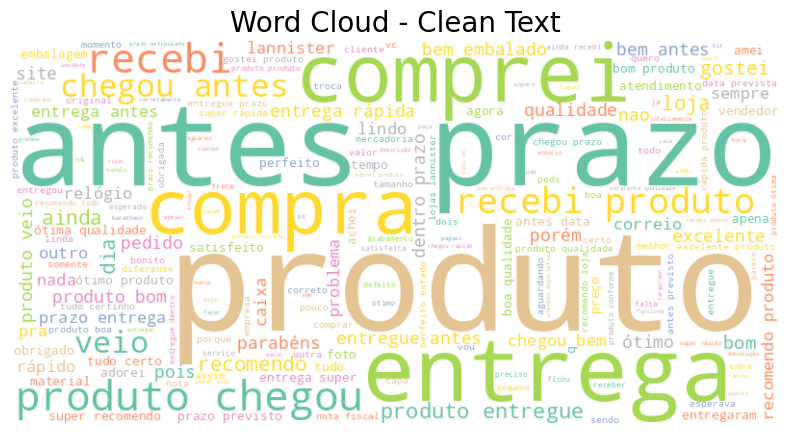

In [ ]:
# Concatenate all non-null texts from the 'cleaned_text' column into a single string
text_combined = " ".join(nlp_df['review_comment_message_clean'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Set2').generate(text_combined)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud - Clean Text",fontsize=20)
plt.axis("off")  # Remove the axes
plt.show()

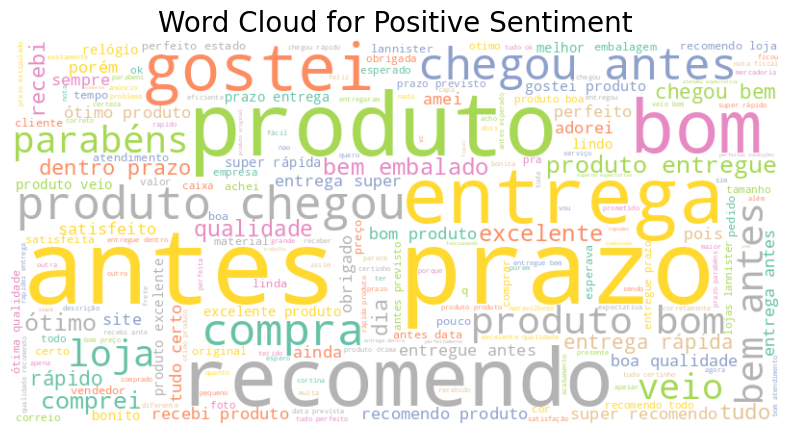

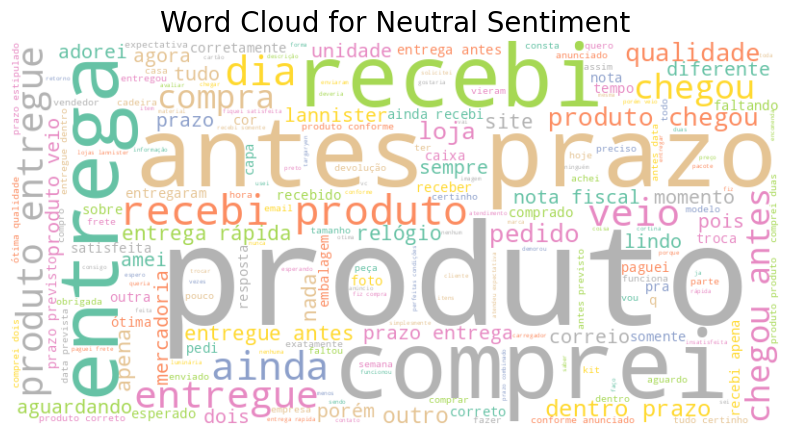

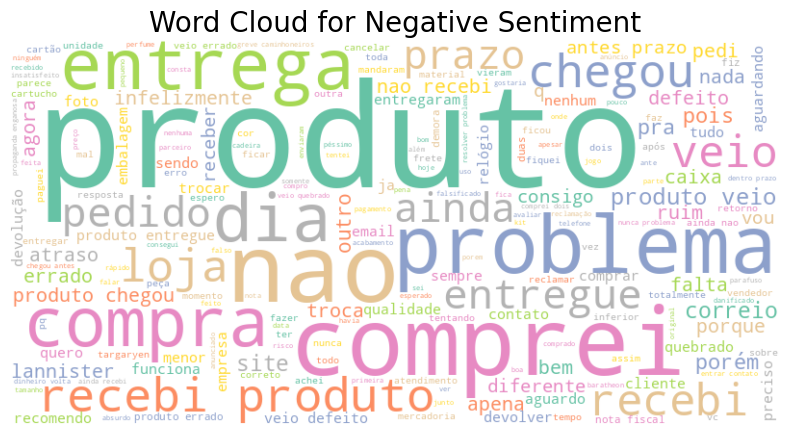

In [ ]:
def plot_word_clouds_by_sentiment(df, text_column='review_comment_message_clean', sentiment_column='review_comment_message_clean_sentiment'):
    # Filter text by sentiment
    sentiments = ['Positive', 'Neutral', 'Negative']

    for sentiment in sentiments:
        # Filter data by current sentiment
        text_data = " ".join(df[df[sentiment_column] == sentiment][text_column].dropna())

        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Set2').generate(text_data)

        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {sentiment} Sentiment', fontsize=20)
        plt.show()

# Generate word clouds based on sentiment for the specified columns
plot_word_clouds_by_sentiment(nlp_df, 'review_comment_message_clean', 'review_comment_message_clean_sentiment')


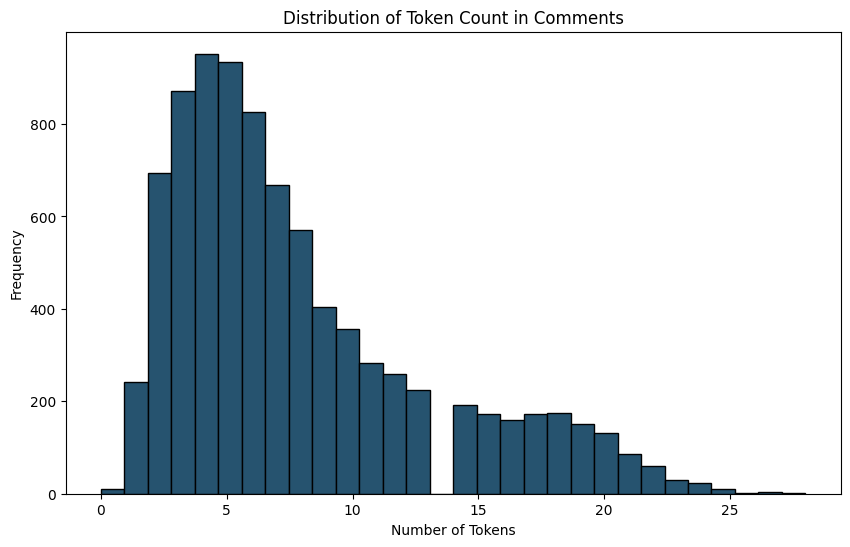

In [ ]:
def plot_token_count_distribution(df, token_column='review_comment_message_tokens'):
    # Calculate the number of tokens for each entry
    df['token_count'] = df[token_column].apply(len)

    # Plot the distribution of token counts
    plt.figure(figsize=(10, 6))
    plt.hist(df['token_count'], bins=30, edgecolor='black')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.title('Distribution of Token Count in Comments')
    plt.show()

# Generate the token count distribution plot
plot_token_count_distribution(nlp_df, 'review_comment_message_tokens')

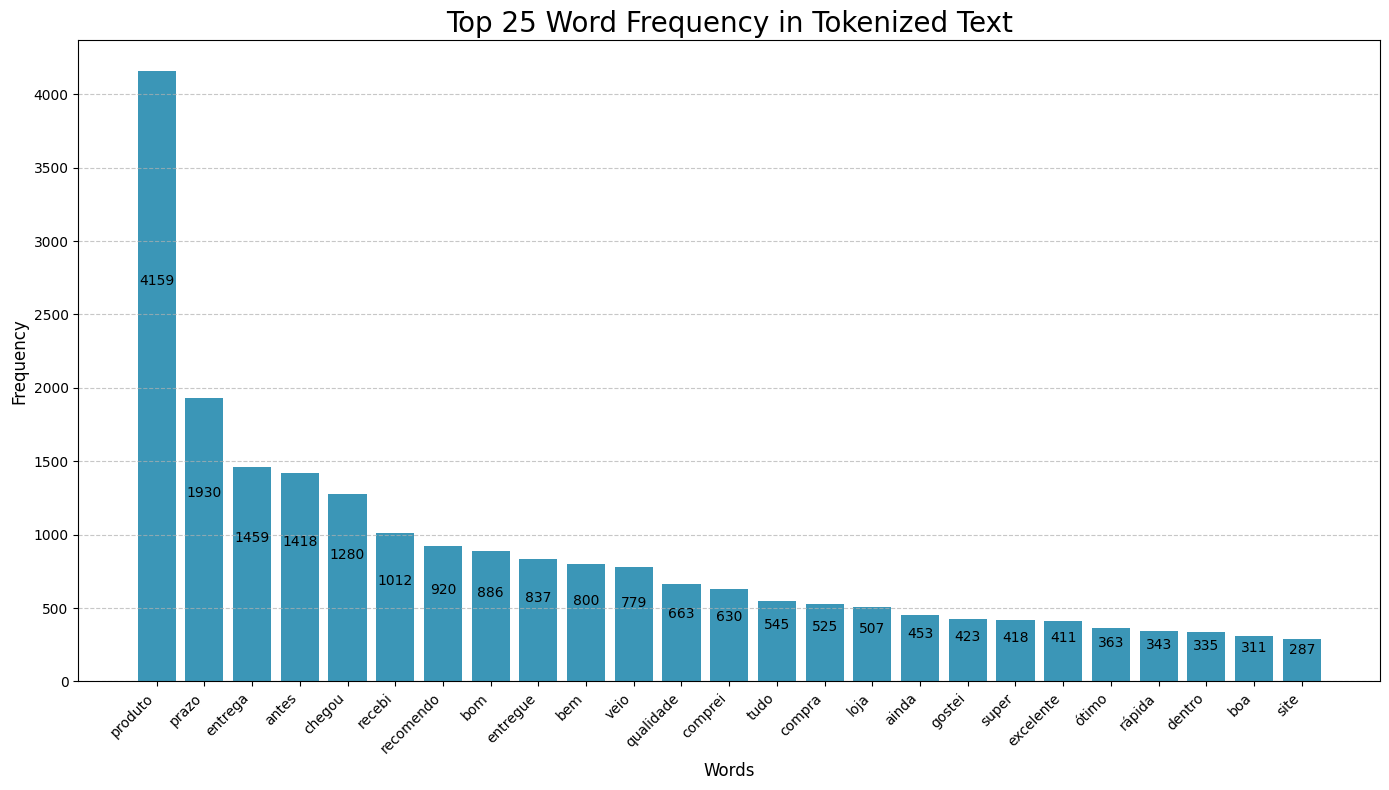

In [ ]:
# Function to get top N tokens
def get_top_tokens(df, token_column='review_comment_message_tokens', top_n=50):
  # Flatten the list of tokenized reviews into one big list of tokens
    all_tokens = [token for tokens in df[token_column] for token in tokens]
    token_counts = Counter(all_tokens)
    return token_counts.most_common(top_n)

  # Function to create a DataFrame from frequency counts
def create_frequency_df(counter, columns=['Word', 'Frequency']):
    return pd.DataFrame(counter.items(), columns=columns)

# General plotting function for bar charts
def plot_top_frequencies(df, title, xlabel, column_name):
    plt.figure(figsize=(14, 8))
    bars = plt.bar(df[column_name], df['Frequency'], color=colors[1])

    # Add labels
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2., bar.get_height() - max(5, bar.get_height() * 0.35),
                 f'{int(bar.get_height())}', ha='center', color='black', fontsize=10)

    # Customize and show plot
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(title, fontsize=20)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Get top tokens and plot
top_50_tokens = get_top_tokens(nlp_df, 'review_comment_message_tokens', 50)
top_50_tokens_df = create_frequency_df(dict(top_50_tokens))
plot_top_frequencies(top_50_tokens_df.head(25), 'Top 25 Word Frequency in Tokenized Text', 'Words', 'Word')

In [ ]:
# N-gram generator and frequency counter
def get_top_ngrams(tokens_list, n=2, top_n=25):
    ngram_counts = Counter(
        ngram for tokens in tokens_list if tokens for ngram in ngrams(tokens, n)
    )
    # Create DataFrame directly from the most common n-grams
    return pd.DataFrame(ngram_counts.most_common(top_n), columns=['Bigram', 'Frequency'])

# Generate top 25 bigrams
top_bigrams_df = get_top_ngrams(nlp_df['review_comment_message_tokens'], n=2, top_n=25)


print(top_bigrams_df)

                 Bigram  Frequency
0        (antes, prazo)       1020
1     (produto, chegou)        409
2       (chegou, antes)        380
3   (produto, entregue)        358
4     (recebi, produto)        355
5       (dentro, prazo)        242
6          (bem, antes)        233
7        (produto, bom)        224
8     (entrega, rápida)        204
9       (produto, veio)        193
10      (bem, embalado)        176
11    (entregue, antes)        168
12     (entrega, antes)        150
13        (chegou, bem)        146
14   (super, recomendo)        127
15     (prazo, entrega)        125
16        (tudo, certo)        119
17     (ótimo, produto)        118
18     (boa, qualidade)        110
19        (antes, data)        107
20   (ótima, qualidade)        107
21     (entrega, super)        107
22    (prazo, previsto)        103
23     (prazo, produto)         99
24       (nota, fiscal)         96


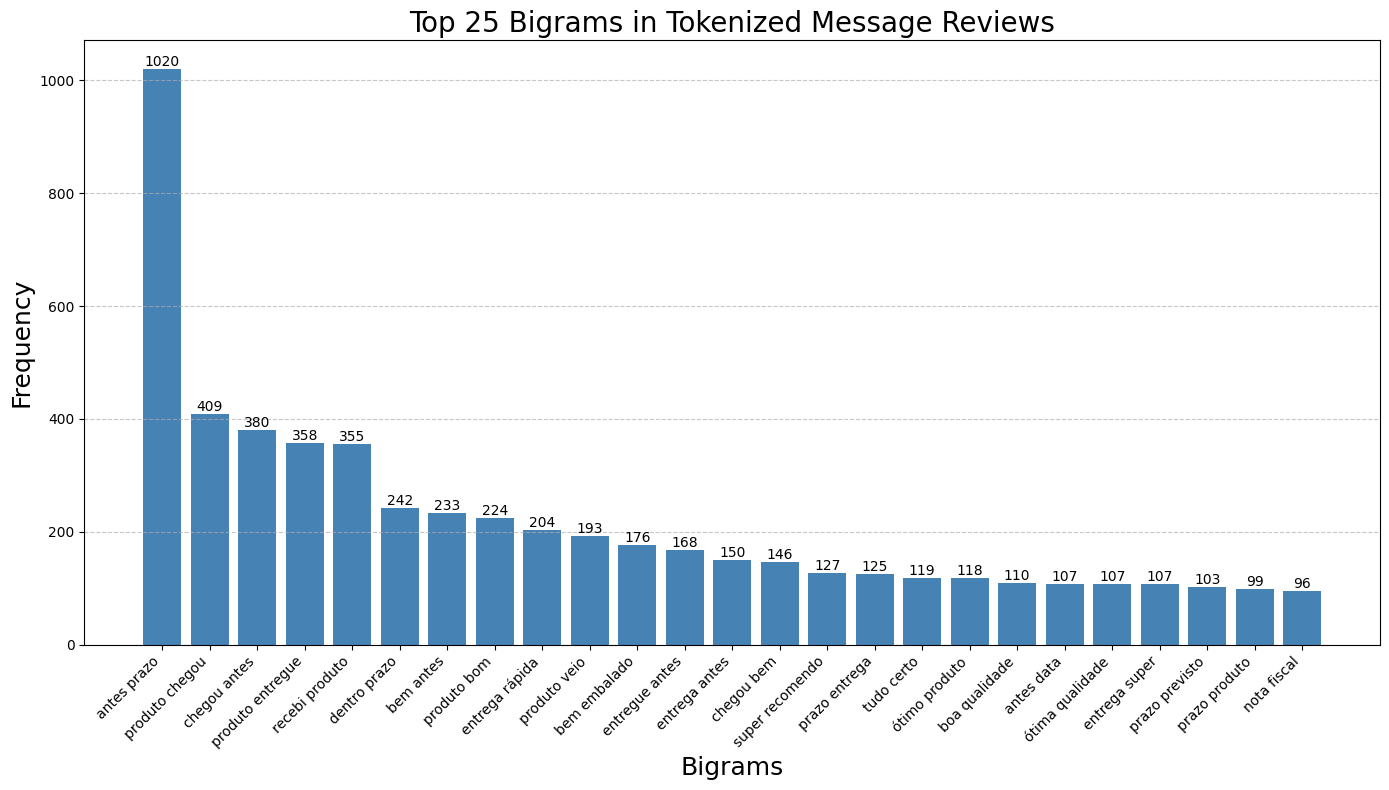

In [ ]:
# Bar chart visualization of bigram frequencies
def create_bigram_visualization(top_bigrams_df, figsize=(14, 8), color='steelblue', rotation=45):

    # Create figure with specified size
    plt.figure(figsize=figsize)

    # Format bigrams into readable strings
    x_labels = [' '.join(gram) for gram in top_bigrams_df['Bigram']]

    # Create the bar plot
    bars = plt.bar(x_labels, top_bigrams_df['Frequency'], color=color)

    # Customize the plot appearance
    plt.xticks(rotation=rotation, ha='right')
    plt.xlabel('Bigrams', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.title('Top 25 Bigrams in Tokenized Message Reviews', fontsize=20)

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    # Adjust layout to prevent label cutoff
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    return plt.gcf()

fig = create_bigram_visualization(top_bigrams_df)
plt.show()

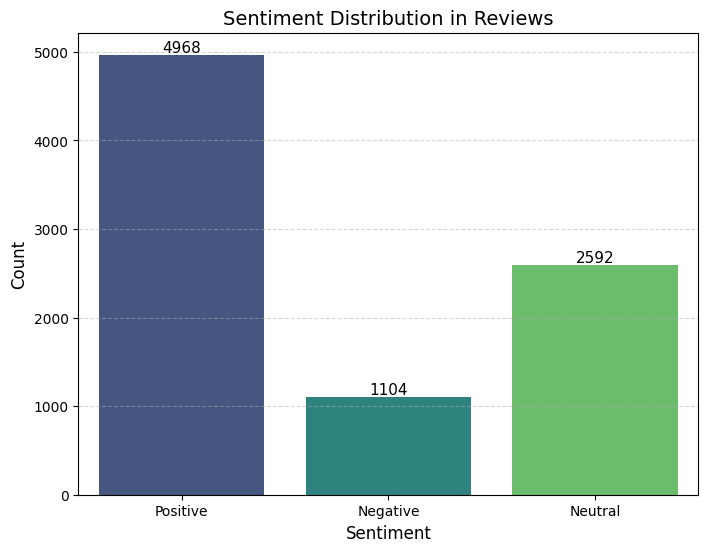

In [ ]:
# Plot the sentiment Review count
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="review_comment_message_clean_sentiment",
                      hue="review_comment_message_clean_sentiment",data=nlp_df,palette="viridis")

# Add labels and title
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Sentiment Distribution in Reviews", fontsize=14)

# Display value labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Reduce gridline visibility for a cleaner look
plt.grid(visible=True, axis='y', linestyle='--', alpha=0.5)

plt.show()

# 8. Data Preprocessing for Machine Learning

In [ ]:
# Feature and label separation
X = nlp_df['review_comment_message'] # Text column
y = nlp_df['review_comment_message_clean_sentiment'] # Target column

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Encoding: Transforming Categorical Data for Machine Learning

In [ ]:
# Create label encoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Check if the conversion was successful
print(f"unique values in y_train_encoded after encoding: {y_train_encoded}")

unique values in y_train_encoded after encoding: [1 2 2 ... 2 1 2]


## TF-IDF Vectorization: Transforming Text into Meaningful Numerical Representations

In [ ]:
# Create TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000) # Optional limit for the number of features

# Transform text to TF-IDF matrix
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Convert to arrays for better visualization
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# 8. Machine Learning

In [55]:
# Initialize models
models = {
    "GaussianNB": GaussianNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=50, random_state=42),
    "LogisticRegression": LogisticRegression(random_state=50, max_iter=1000),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=45),
    "XGBClassifier": XGBClassifier(n_estimators=50, random_state=42),
    "LGBMClassifier": LGBMClassifier(boosting_type='gbdt', bagging_fraction=0.9,
                                     learning_rate=0.05, feature_fraction=0.9, bagging_freq=50,
                                     verbosity=-1, verbose=50),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2),
    "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators=50, random_state=42),
    "SVC": SVC(kernel='linear', random_state=42, probability=True),
    "CatBoostClassifier": CatBoostClassifier(verbose=0, random_state=42)
}

# Model Training and Calculate Accuracy Scores

# Initialize an empty list to store results for each model
results = []
for name, model in models.items():
    model.fit(X_train_dense, y_train_encoded)
    train_accuracy = accuracy_score(y_train_encoded, model.predict(X_train_dense))
    test_accuracy = accuracy_score(y_test_encoded, model.predict(X_test_dense))
    results.append({"Model": name, "Training Accuracy": train_accuracy, "Testing Accuracy": test_accuracy})

pd.DataFrame(results)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Model  Training Accuracy  Testing Accuracy
0                   GaussianNB           0.554177          0.356607
1       DecisionTreeClassifier           0.999711          0.830352
2       RandomForestClassifier           0.999711          0.829775
3           LogisticRegression           0.936084          0.868436
4           AdaBoostClassifier           0.621555          0.608771
5                XGBClassifier           0.916174          0.867282
6               LGBMClassifier           0.920502          0.877669
7         KNeighborsClassifier           0.556197          0.510675
8   GradientBoostingClassifier           0.832925          0.824005
9                          SVC           0.958592          0.888055
10          CatBoostClassifier           0.930313          0.885747

## Feature Importances

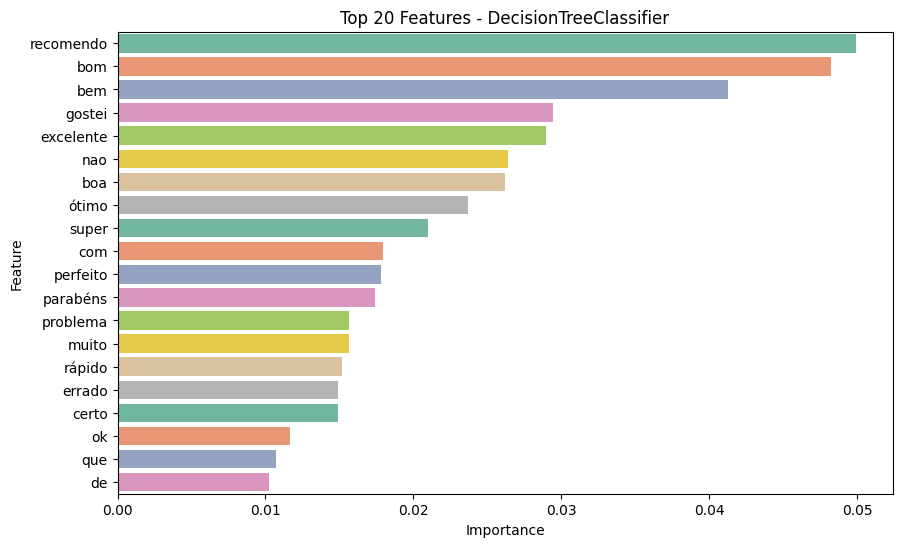

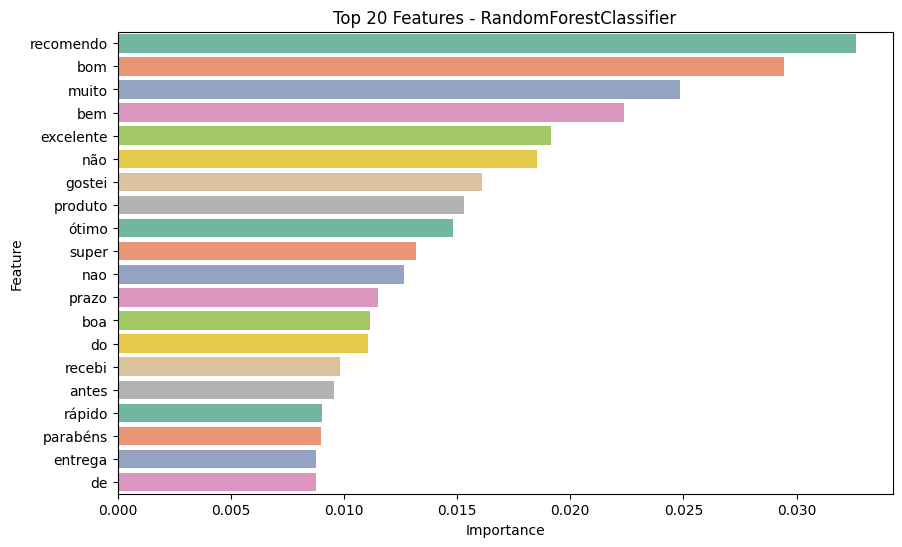

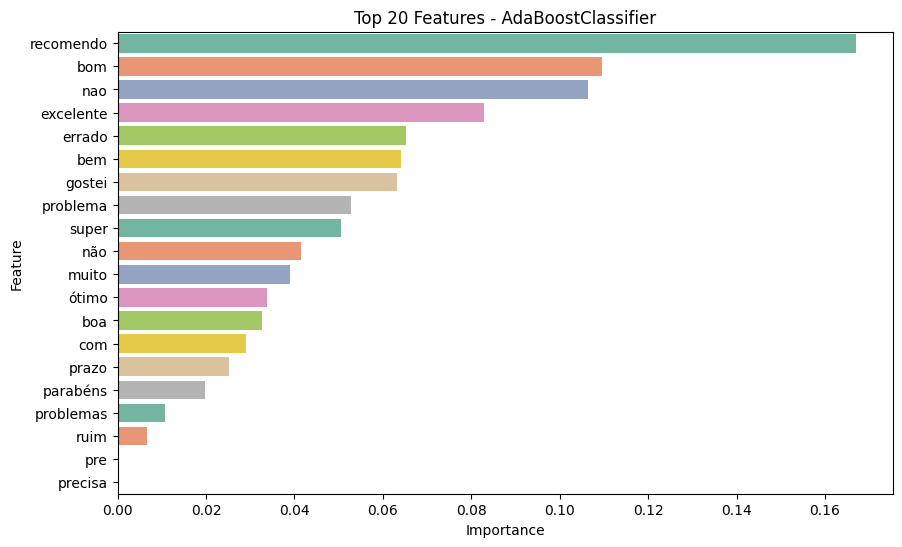

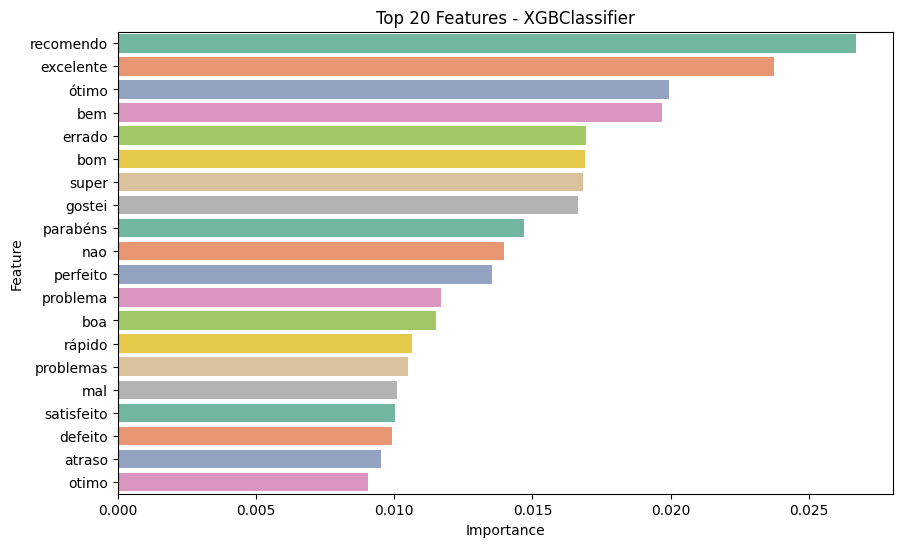

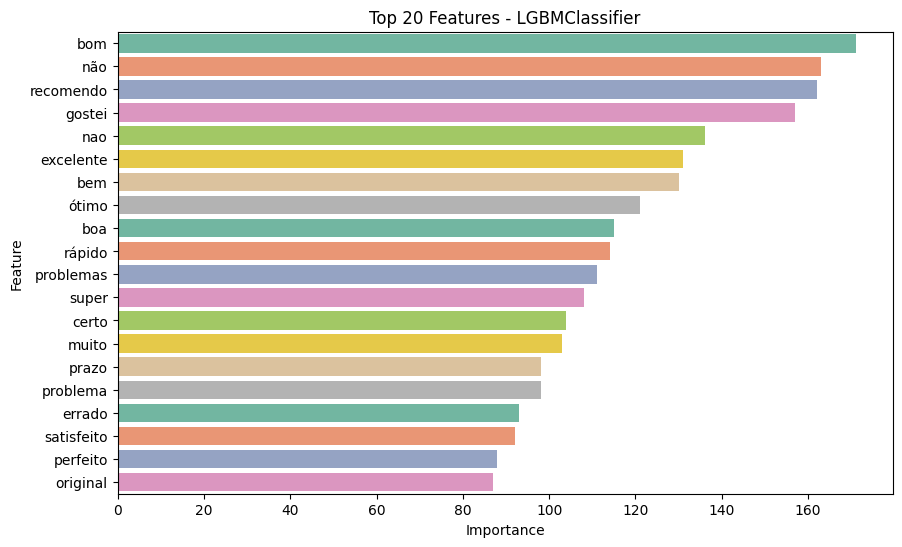

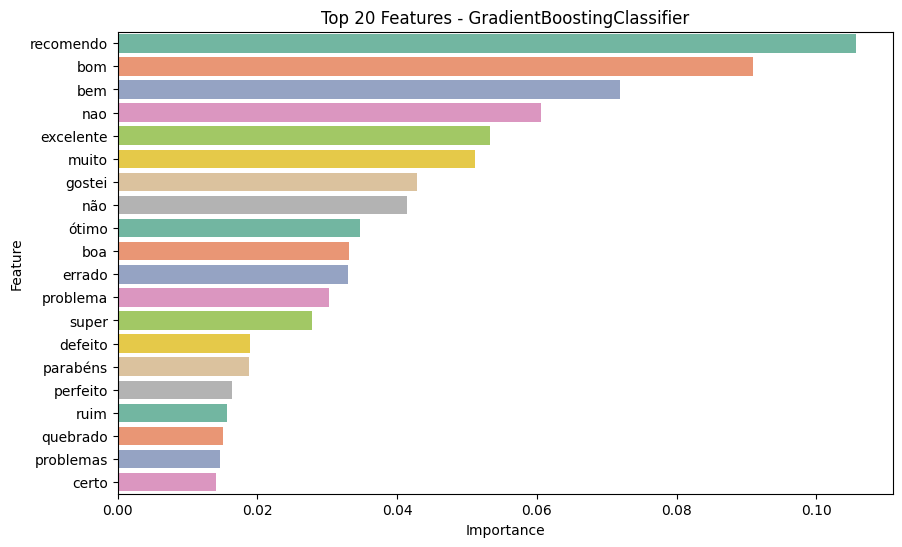

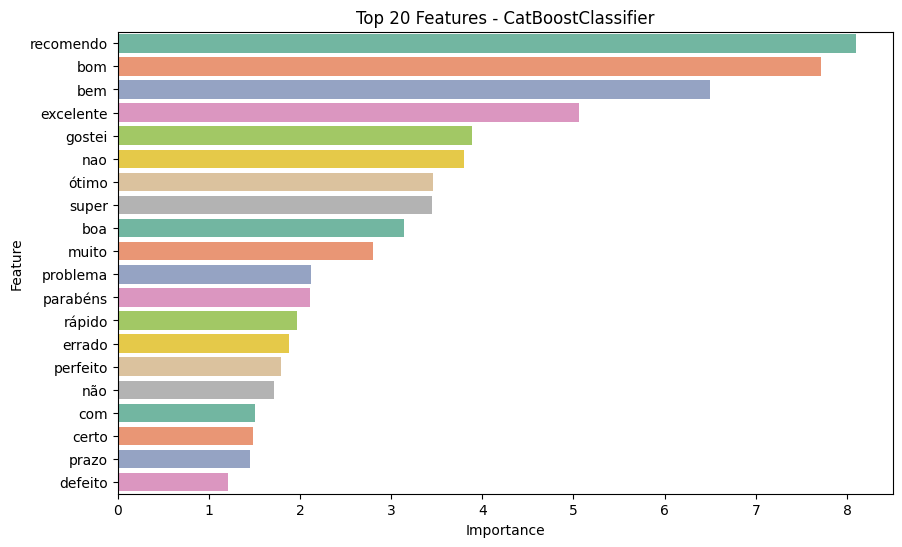

In [ ]:
feature_importances = []
feature_names = vectorizer.get_feature_names_out()

for name, model in models.items():
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values(by="Importance", ascending=False).head(20)

        plt.figure(figsize=(10, 6))
        sns.barplot(x="Importance", y="Feature", data=imp_df, hue="Feature", palette='Set2', legend=False)
        plt.title(f"Top 20 Features - {name}")
        plt.show()

## Confusion Matrix Heatmaps: For evaluating classification model performance

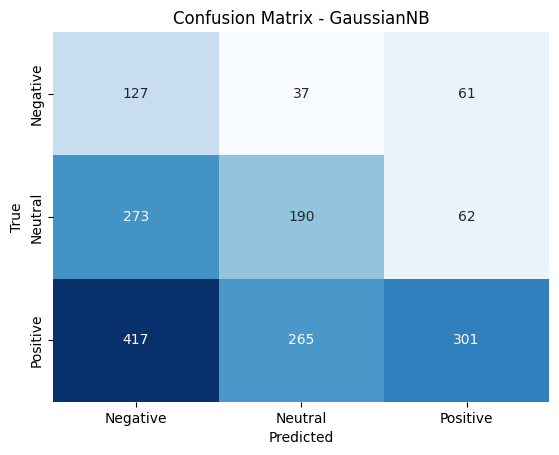

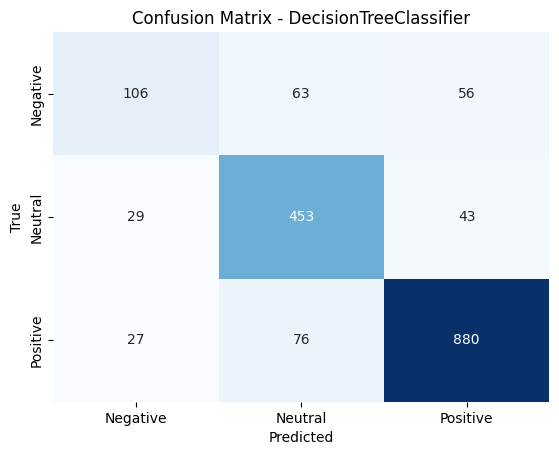

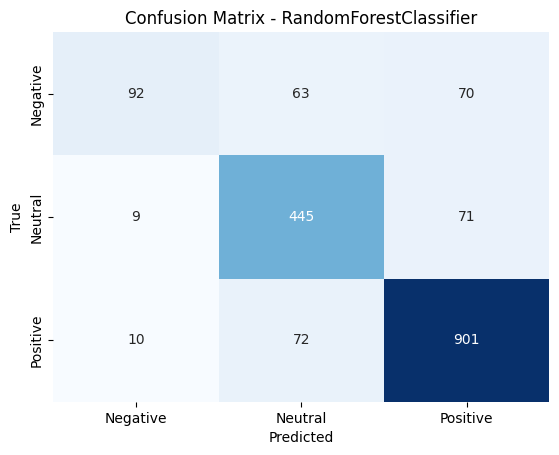

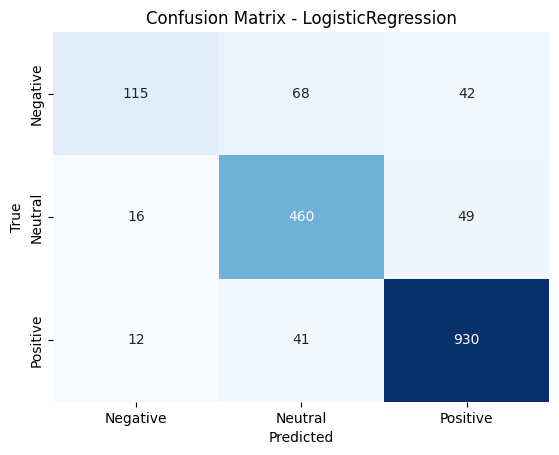

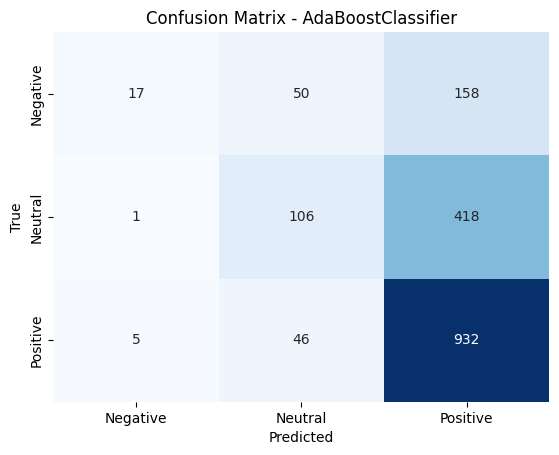

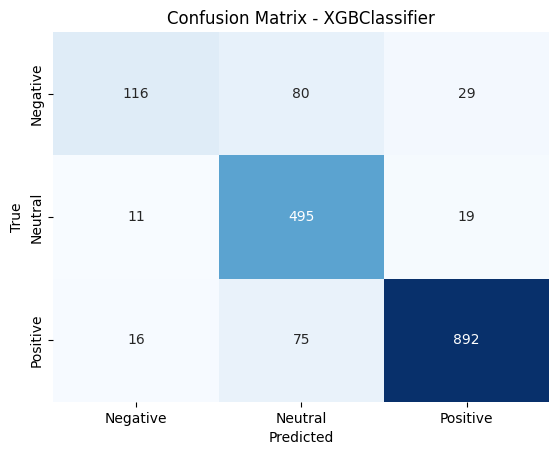

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


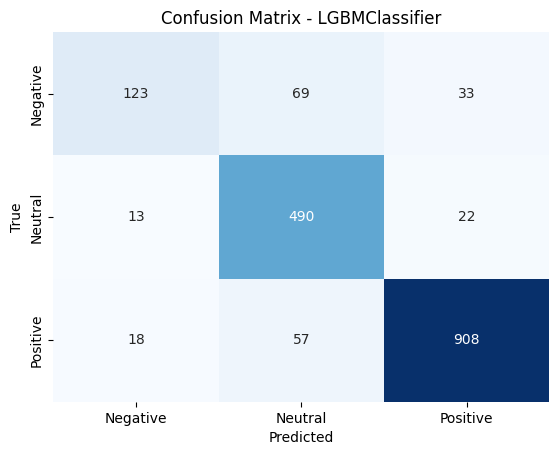

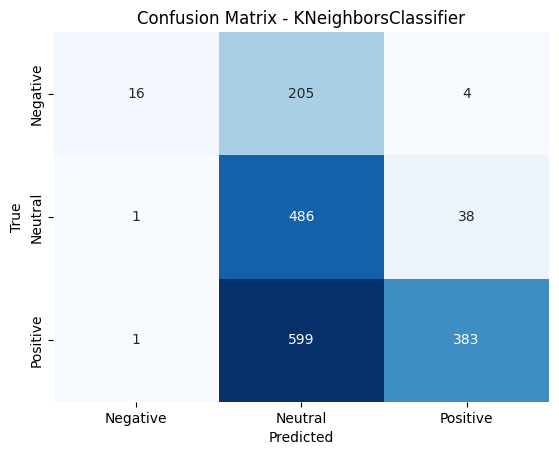

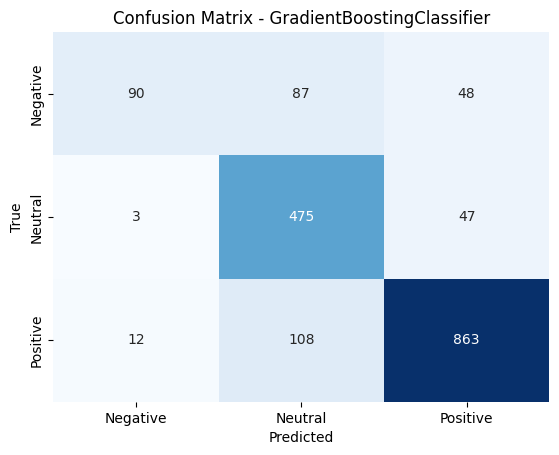

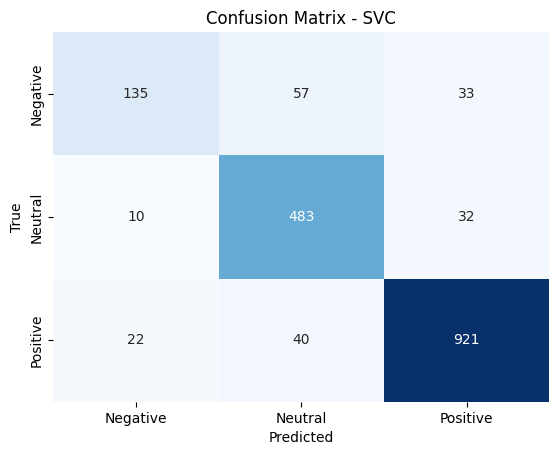

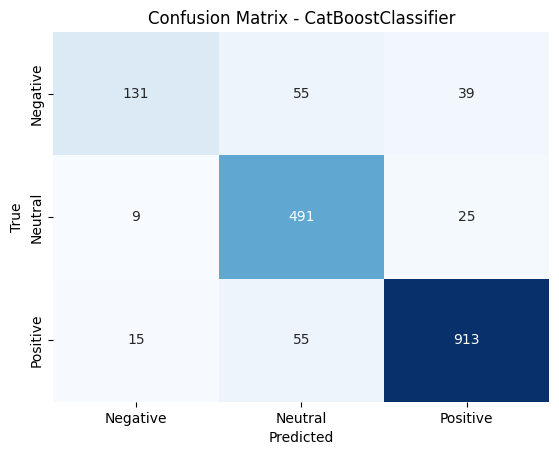

In [ ]:
# Confusion matrix plots
for name, model in models.items():
    y_pred = model.predict(X_test_dense)
    cm = confusion_matrix(y_test_encoded, y_pred)

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Receiver Operating Characteristic (ROC) curves

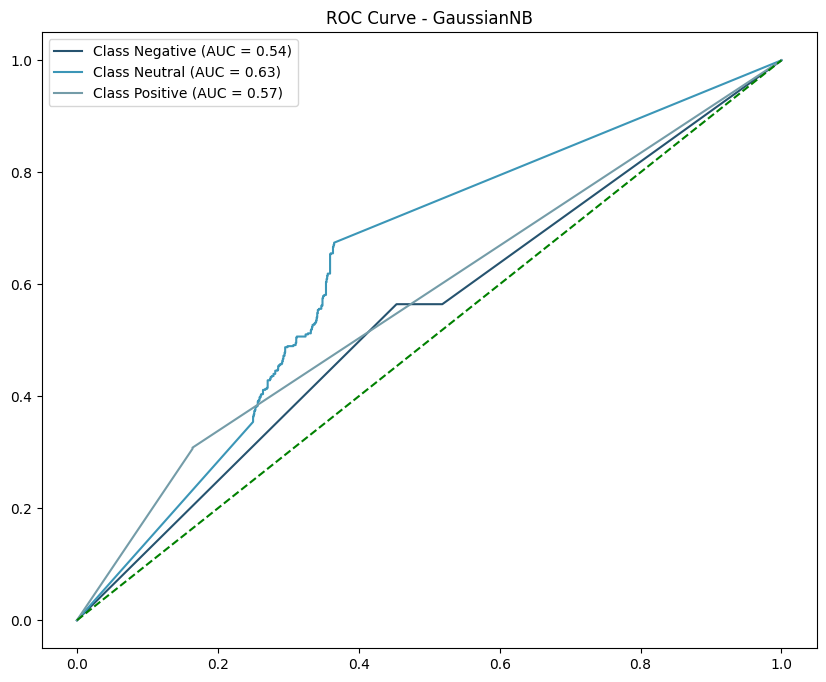

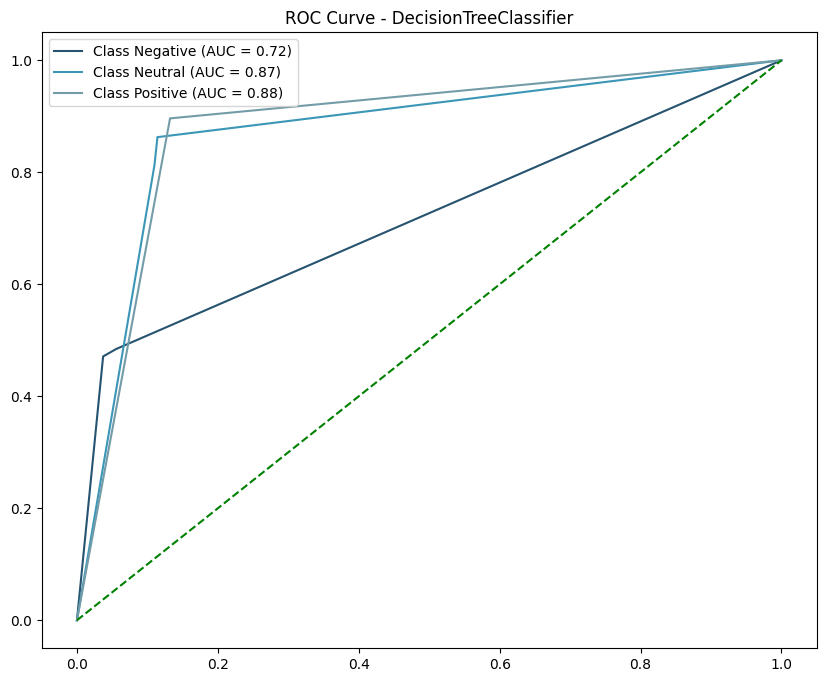

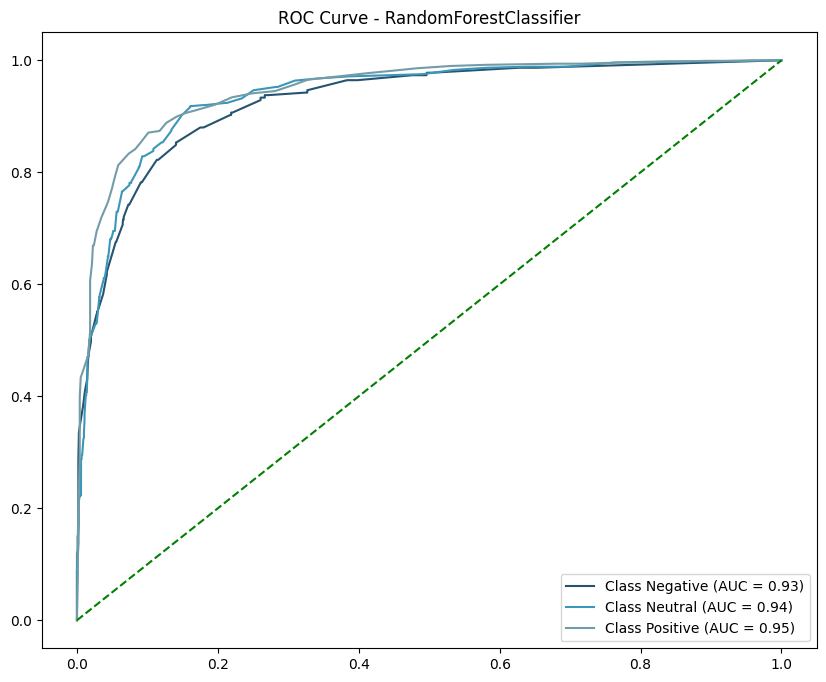

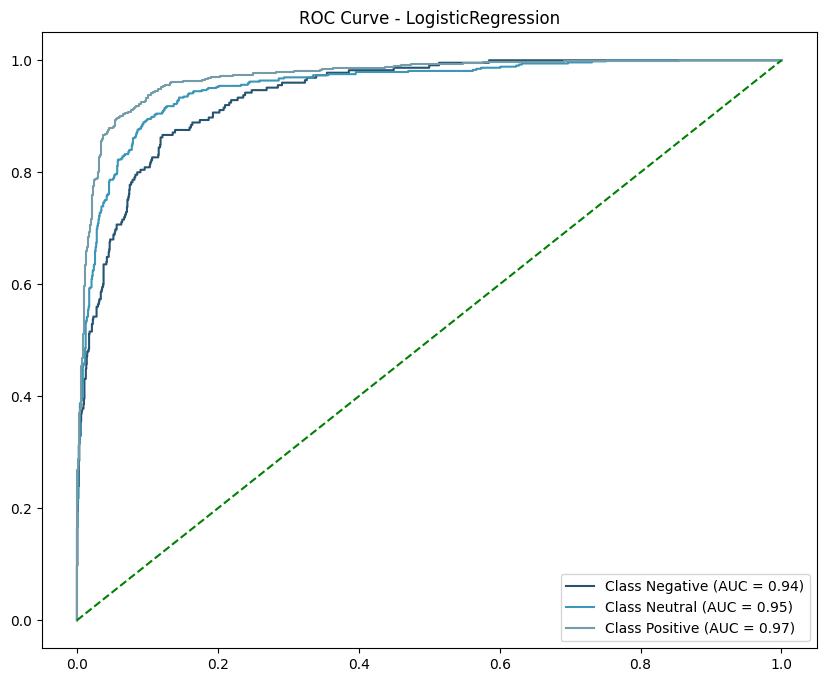

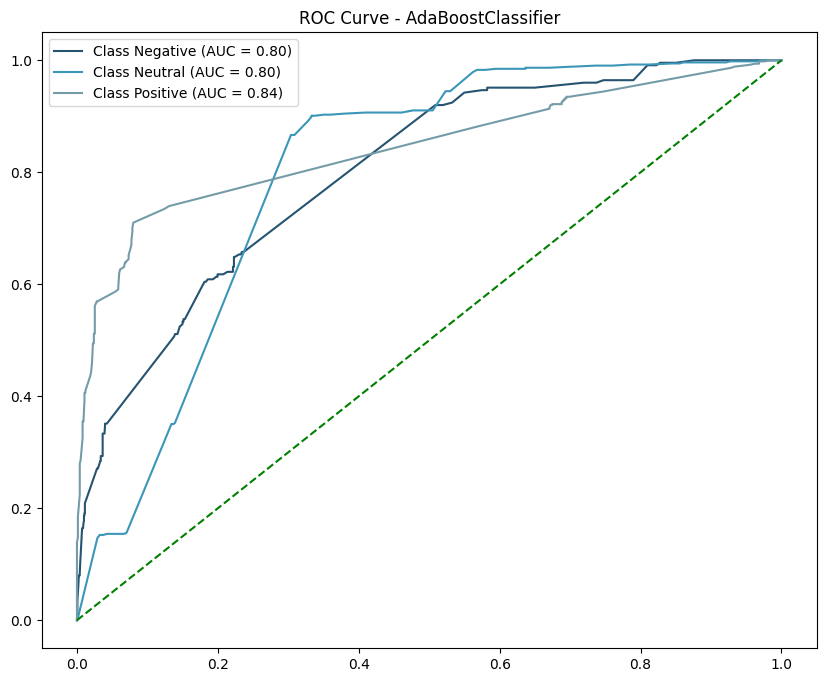

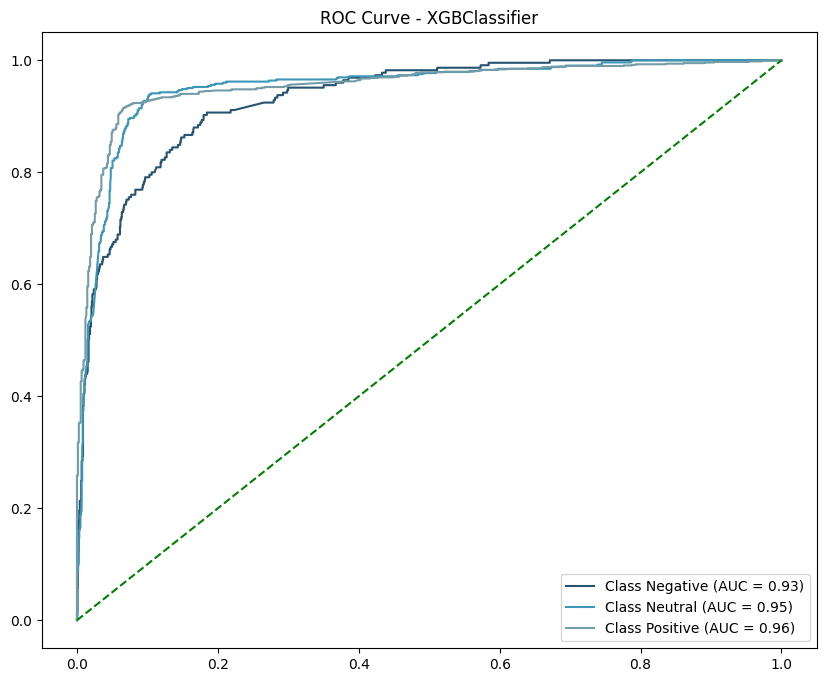

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


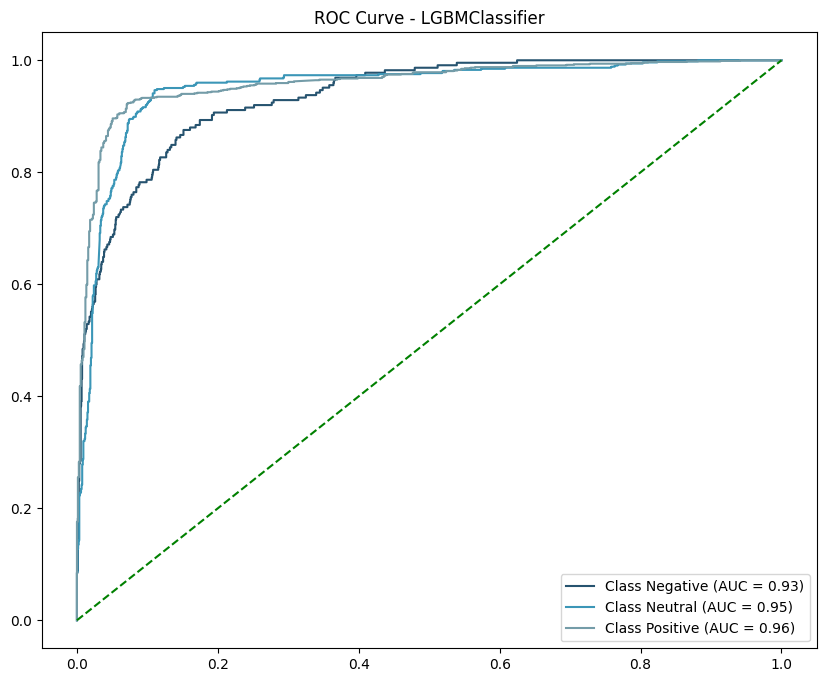

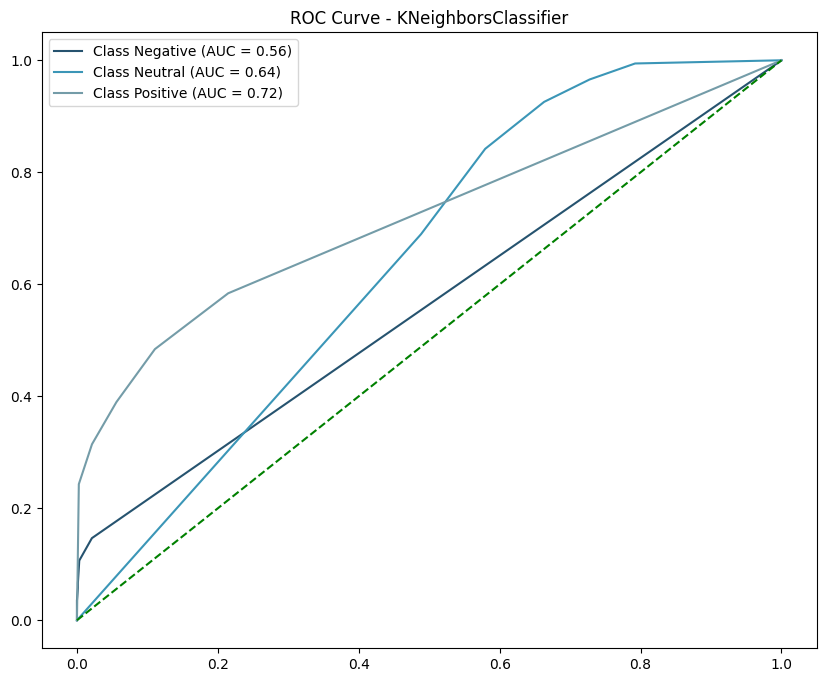

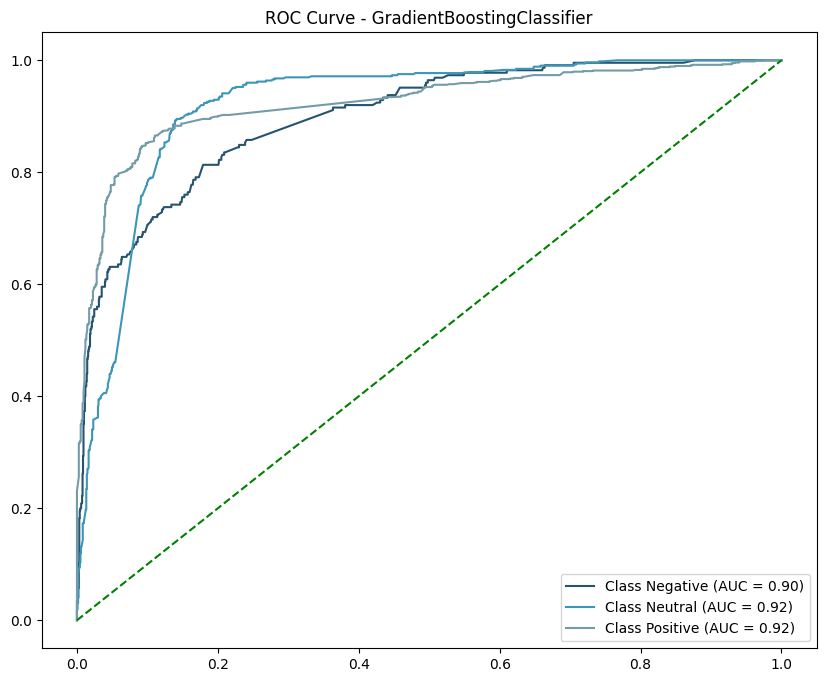

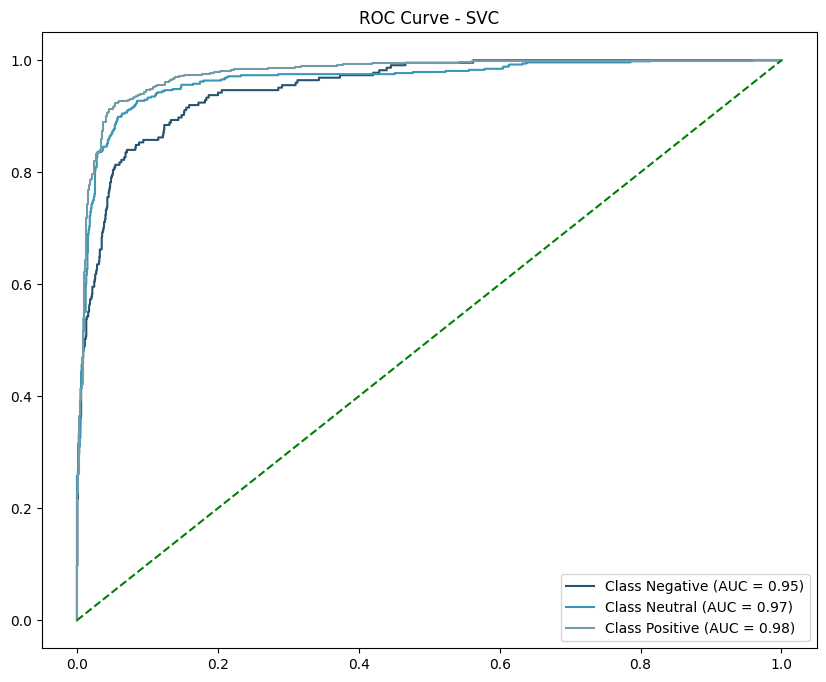

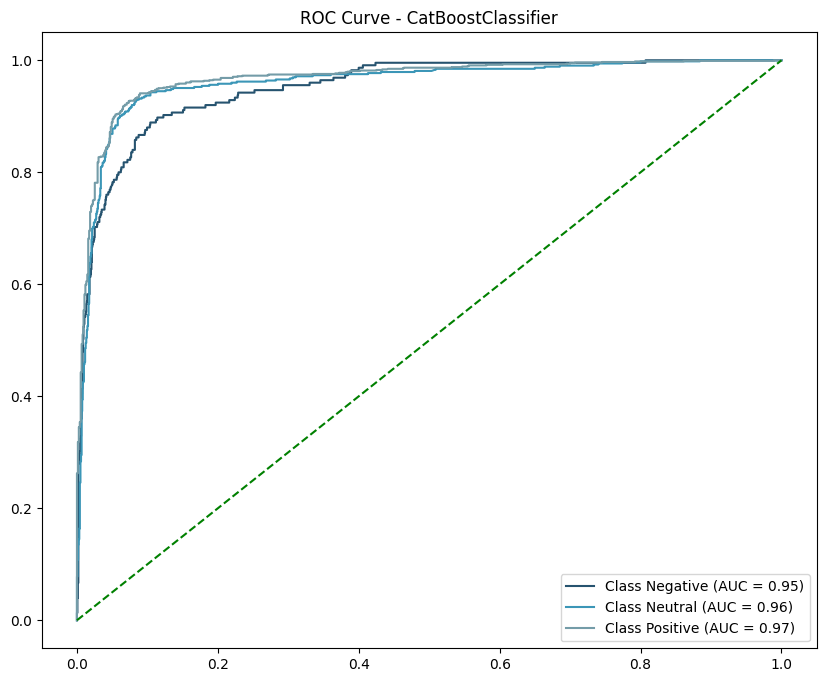

In [ ]:
# Convert class labels into binary matrix format (one-hot encoding)
y_test_binarized = label_binarize(y_test_encoded, classes=np.unique(y_test_encoded))
n_classes = y_test_binarized.shape[1]

for name, model in models.items():
    plt.figure(figsize=(10, 8))

# Get prediction probabilities
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_dense)
    else:
        y_decision = model.decision_function(X_test_dense)
        y_prob = (y_decision - y_decision.min()) / (y_decision.max() - y_decision.min())

# Calculate and Plot ROC Curves for Each Class
    for class_id in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, class_id], y_prob[:, class_id])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {label_encoder.inverse_transform([class_id])[0]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

# Classification Report: Performance evaluation metrics

In [ ]:
for name, model in models.items():
    y_pred = model.predict(X_test_dense)
    print(f"Classification Report for {name}")
    print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

Classification Report for GaussianNB
              precision    recall  f1-score   support

    Negative       0.16      0.56      0.24       225
     Neutral       0.39      0.36      0.37       525
    Positive       0.71      0.31      0.43       983

    accuracy                           0.36      1733
   macro avg       0.42      0.41      0.35      1733
weighted avg       0.54      0.36      0.39      1733

Classification Report for DecisionTreeClassifier
              precision    recall  f1-score   support

    Negative       0.65      0.47      0.55       225
     Neutral       0.77      0.86      0.81       525
    Positive       0.90      0.90      0.90       983

    accuracy                           0.83      1733
   macro avg       0.77      0.74      0.75      1733
weighted avg       0.83      0.83      0.83      1733

Classification Report for RandomForestClassifier
              precision    recall  f1-score   support

    Negative       0.83      0.41      0.55     

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Classification Report for KNeighborsClassifier
              precision    recall  f1-score   support

    Negative       0.89      0.07      0.13       225
     Neutral       0.38      0.93      0.54       525
    Positive       0.90      0.39      0.54       983

    accuracy                           0.51      1733
   macro avg       0.72      0.46      0.40      1733
weighted avg       0.74      0.51      0.49      1733

Classification Report for GradientBoostingClassifier
              precision    recall  f1-score   support

    Negative       0.86      0.40      0.55       225
     Neutral       0.71      0.90      0.79       525
    Positive       0.90      0.88      0.89       983

    accuracy                           0.82      1733
   macro avg       0.82      0.73      0.74      1733
weighted avg       0.84      0.82      0.82      1733

Classification Report for SVC
              precision    recall  f1-score   support

    Negative       0.81      0.60      0.69       225

# Performance Metrics and Highlighting

In [ ]:
# Collect performance metrics
performance_data = []
for name, model in models.items():
    y_pred = model.predict(X_test_dense)
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test_encoded, y_pred),
        "Precision": precision_score(y_test_encoded, y_pred, average='weighted'),
        "Recall": recall_score(y_test_encoded, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test_encoded, y_pred, average='weighted')
    }
    performance_data.append(metrics)

# Convert list of dictionaries to DataFrame
performance_df = pd.DataFrame(performance_data)

# Apply highlight to numeric columns only
highlighted_df = (
    performance_df.style
    .highlight_max(
        subset=performance_df.select_dtypes(include='number').columns,  # Only numeric columns
        color="lightblue",
        axis=0
    )
)

# Display the styled DataFrame
highlighted_df

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
